
# Methodology & Colab Run Guide

**Goal**
Predict the next items a user will add to cart (top-k) using lightweight, explainable signals: co-visitation from historical baskets plus simple context (channel, subchannel, occasion, store), with recency decay and diversity control.

**Inputs**
Tabular transactions with columns such as: `order_id/basket_id`, `timestamp`, `item_name` (or list), `channel`, `subchannel`, `occasion`, `store`. Files may be CSV/CSV.GZ.

**Data Preparation**

1. Clean item names (lowercase, trim, remove system/beverage noise).
2. Group rows into baskets (one list of items per order/session).
3. Create two evaluations:

   * **Strict Leave-One-Out (LOO):** hide one real item per basket (≥2 items) to test recall\@k.
   * **Temporal split:** sort by time; train on the earliest 80%, test on the latest 20% to mimic real drift.

**Co-Visitation Graphs (Multi-Context)**

* Count co-occurrences for pairs (A→B) at multiple levels: **global**, **by channel**, **by subchannel**, **by occasion**, **by store**.
* Apply **recency decay** so recent co-occurrences weigh more.
* Keep top-N neighbors per item for fast candidate generation.

**Scoring & Recommendation**

* For a live cart `C`, gather candidates from neighbors of each item in `C`.
* Compute a **context-aware score** = weighted sum of (global co-vis + matching-context co-vis), with smoothing.
* Aggregate over seeds in `C` (sum/max with per-seed caps).
* Apply **diversity (MMR)** to balance relevance vs. novelty and avoid near-duplicates.
* Break ties by global popularity or recent frequency.
* Return top-k (e.g., k=3).

**Evaluation Metrics**

* **Strict LOO:** Recall\@1/2/3, MAP\@3, NDCG\@3.
* **Temporal (last 20%):** same metrics to assess robustness under drift.

**Artifacts & Visuals**

* Saved: baskets, co-vis maps, recommendation CSVs, and plots (coverage, popularity vs. gain, ablations, cart size histograms).
* Outputs are written to an `outputs/` folder.

**Key Hyperparameters to Tune**

* Recency **half-life**; **top-N** neighbors per item; context **weights** (global vs. channel/subchannel/occasion/store); **MMR λ** (diversity); **candidate cap** per seed.

---

## How to Run in Google Colab

1. **Environment** — Python 3; install deps (pandas, numpy, tqdm, ujson).
2. **Data** — upload files or mount Google Drive; set paths.
3. **Config** — set input paths and `OUT_DIR`.
4. **Build Train Baskets** — parse/clean → group to baskets → cache.
5. **Build Test Sets** — create Strict LOO and Temporal 80/20 splits.
6. **Fit Model** — build co-vis maps (global + contexts) with decay.
7. **Sanity-Check Recs** — run recommendations for a sample cart.
8. **Evaluate** — run Strict LOO and Temporal metrics; inspect tables/plots.
9. **Tune & Re-run** — adjust half-life, context weights, top-N, MMR λ; compare metrics.
10. **Export** — save metrics tables/CSVs and figures to Drive.

**Troubleshooting**

* Malformed CSV rows → use robust reader / re-export as UTF-8 with quoting.
* Memory slowdowns → use chunked reading, prune ultra-rare items, reduce neighbor top-N.
* Cold-start items → fall back to global popularity or category best-sellers.


In [2]:
# ==================== Wings R Us — End-to-end Recommender (Colab-ready) ====================
# Features:
# - Robust CSV ingestion (fixes ParserError: EOF inside string)
# - Safe JSON parsing from ORDERS
# - Food-only filtering (excludes beverages/system charges)
# - Context-blended co-visitation scoring (Channel / Subchannel / Occasion / Store)
# - 3 unique, in-menu recommendations (never items already in cart)
# - Strict LOO evaluation (R@1/2/3, MAP@3, NDCG@3)
# - 10 publication-ready plots
# - Submission writer (XLSX + CSV)
# ===========================================================================================

!pip -q install openpyxl tqdm ujson

import os, json, re, math, random, time, ujson
from collections import defaultdict, Counter
from statistics import mean
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------- Utils: cleaning & filters -----------------------------------
def clean_item_name(name: str) -> str:
    if not isinstance(name, str): return ""
    s = name.strip()
    s = re.sub(r"\s+", " ", s)
    return s

# Items we want to exclude from recommendations:
SYSTEM_KEYWORDS = [
    "tip","fee","bag","delivery","service","charge","memo","blankline","asap",
    "paid","subtotal","tax","container","packaging","utensil","discount","coupon",
    "rounding","surcharge","convenience","cash"
]
BEVERAGE_KEYWORDS = [
    "drink","soda","cola","pepsi","coke","sprite","fanta","mountain dew","md",
    "tea","iced tea","lemonade","juice","water","bottle","can","oz","milk","shake"
]

def is_system_or_beverage(text: str) -> bool:
    if not isinstance(text, str): return True
    t = text.lower()
    return any(k in t for k in SYSTEM_KEYWORDS) or any(k in t for k in BEVERAGE_KEYWORDS)

# Useful: keep dips/sides as food (ranch dip etc.)
def is_food_like(text: str) -> bool:
    if not isinstance(text, str): return False
    if is_system_or_beverage(text): return False
    t = text.lower()
    # Whitelist patterns commonly seen in WUR data
    food_markers = [
        "wing","grilled","spicy","mild","honey","bbq","buffalo","garlic","hot","combo",
        "fries","strip","tender","crispy","corn","onion","ring","coleslaw","bread",
        "sub","sandwich","dip","sauce","ranch","blue cheese","honey mustard","breaded"
    ]
    return any(k in t for k in food_markers)

# ----------------------------- Robust ORDERS JSON parsing -----------------------------------
def parse_orders_json(orders_json: str) -> list:
    """
    Safely parse nested JSON from ORDERS -> orders[0].item_details[*].item_name
    Returns a list of original (not lowercased) item names.
    """
    if not isinstance(orders_json, str) or not orders_json.strip():
        return []
    j = None
    # Try fastest parser first
    for loader in (ujson.loads, json.loads):
        try:
            j = loader(orders_json)
            break
        except Exception:
            continue
    if j is None:
        return []
    try:
        orders = j.get("orders", [])
        if not orders or not isinstance(orders, list):
            return []
        details = orders[0].get("item_details", [])
        out = []
        for it in details:
            if isinstance(it, dict):
                name = it.get("item_name", "")
            else:
                name = str(it)
            name = clean_item_name(name)
            if name and is_food_like(name):
                out.append(name)
        return out
    except Exception:
        return []

# ----------------------------- Robust CSV reader for training --------------------------------
def iter_train_chunks(path, use_cols, chunksize=100000):
    """
    Generator that yields DataFrame chunks, switching to python engine and skipping bad lines
    if the fast path fails.
    """
    try:
        for ch in pd.read_csv(path, usecols=use_cols, chunksize=chunksize, low_memory=False):
            yield ch
    except pd.errors.ParserError:
        print("⚠️ CSV has malformed rows. Switching to engine='python', on_bad_lines='skip'.")
        for ch in pd.read_csv(
            path, usecols=use_cols, chunksize=chunksize, engine="python",
            on_bad_lines="skip", quotechar='"', escapechar='\\', dtype=str
        ):
            yield ch

# ----------------------------- Build baskets --------------------------------------------------
def build_train_baskets(PATH_TRAIN: str, max_rows: int = None):
    """
    Returns list of dicts:
      {"ORDER_ID": ..., "CUSTOMER_ID": ..., "STORE_NUMBER": ...,
       "ORDER_CHANNEL_NAME": ..., "ORDER_SUBCHANNEL_NAME": ...,
       "ORDER_OCCASION_NAME": ..., "items": [item1, item2, ...] }
    """
    baskets = []
    if not (PATH_TRAIN and os.path.exists(PATH_TRAIN)):
        print("⛔ Train file not found; will build from TEST only.")
        return baskets

    use_cols = ["CUSTOMER_ID","STORE_NUMBER","ORDER_CREATED_DATE","ORDER_ID","ORDERS",
                "ORDER_CHANNEL_NAME","ORDER_SUBCHANNEL_NAME","ORDER_OCCASION_NAME"]
    n_rows = 0
    print("Building training baskets from order_data.csv (this can take time on full file)...")
    for chunk in iter_train_chunks(PATH_TRAIN, use_cols, chunksize=50000):
        for _, r in chunk.iterrows():
            items = parse_orders_json(r.get("ORDERS",""))
            if not items:
                continue
            b = {
                "ORDER_ID": str(r.get("ORDER_ID","")),
                "CUSTOMER_ID": str(r.get("CUSTOMER_ID","")),
                "STORE_NUMBER": str(r.get("STORE_NUMBER","")),
                "ORDER_CHANNEL_NAME": str(r.get("ORDER_CHANNEL_NAME","")),
                "ORDER_SUBCHANNEL_NAME": str(r.get("ORDER_SUBCHANNEL_NAME","")),
                "ORDER_OCCASION_NAME": str(r.get("ORDER_OCCASION_NAME","")),
                "items": items
            }
            baskets.append(b)
            n_rows += 1
            if max_rows and n_rows >= max_rows:
                print(f"  ...stopped early at {max_rows:,} rows (dev mode)")
                return baskets
    print(f"Train baskets built: {len(baskets):,}")
    return baskets

def build_test_carts(PATH_TEST: str):
    """
    Returns:
      test_df (original),
      test_carts: list of dicts with same keys as train baskets + (ORDER_ID from test)
      item_vocab from test (set)
    """
    print("Loading test data ...")
    test_df = pd.read_csv(PATH_TEST)
    # Normalize types to str for safety
    for c in ("CUSTOMER_ID","STORE_NUMBER","ORDER_ID","ORDER_CHANNEL_NAME",
              "ORDER_SUBCHANNEL_NAME","ORDER_OCCASION_NAME","CUSTOMER_TYPE"):
        if c in test_df.columns:
            test_df[c] = test_df[c].astype(str)

    carts = []
    vocab = set()
    for _, r in test_df.iterrows():
        items = [clean_item_name(x) for x in [r.get("item1"), r.get("item2"), r.get("item3")] if isinstance(x,str) and x.strip()]
        # keep only food-like
        items = [x for x in items if is_food_like(x)]
        for x in items: vocab.add(x)
        carts.append({
            "ORDER_ID": str(r.get("ORDER_ID","")),
            "CUSTOMER_ID": str(r.get("CUSTOMER_ID","")),
            "STORE_NUMBER": str(r.get("STORE_NUMBER","")),
            "ORDER_CHANNEL_NAME": str(r.get("ORDER_CHANNEL_NAME","")),
            "ORDER_SUBCHANNEL_NAME": str(r.get("ORDER_SUBCHANNEL_NAME","")),
            "ORDER_OCCASION_NAME": str(r.get("ORDER_OCCASION_NAME","")),
            "items": items
        })
    return test_df, carts, vocab

# ----------------------------- Co-visitation with context ------------------------------------
class CoVisRecommender:
    """
    Context-blended co-visitation recommender.
    Score(item_j | cart, context) ~ sum_i  [ w0*co(i,j) + w_ctx*co_ctx(i,j|context) ] + backoff*pop(j)
    """
    def __init__(self, weights=None, cand_pool=160, backoff_alpha=0.12):
        # weights: (base, channel, subchannel, occasion, store, cart_size_prior)
        self.W = weights or (0.51, 0.24, 0.05, 0.11, 0.15, 0.10)
        self.CAND_POOL = cand_pool
        self.BACKOFF = backoff_alpha

        self.co = defaultdict(Counter)            # base co-vis
        self.co_channel = defaultdict(lambda: defaultdict(Counter))
        self.co_subchannel = defaultdict(lambda: defaultdict(Counter))
        self.co_occasion = defaultdict(lambda: defaultdict(Counter))
        self.co_store = defaultdict(lambda: defaultdict(Counter))
        self.pop = Counter()
        self.item_vocab = set()
        self.item_display = Counter()  # map canonical to most-common display form

        self.cart_size_hist = Counter()

    def _update_display_form(self, items):
        for s in items:
            self.item_display[s] += 1

    def fit(self, baskets):
        """
        baskets: list of dicts with keys ["items", context ...]
        """
        for b in tqdm(baskets, desc="Building co-vis maps"):
            items = [clean_item_name(x) for x in b["items"] if is_food_like(x)]
            items = [x for x in items if x]  # non-empty
            if len(items)==0:
                continue
            self.item_vocab.update(items)
            self._update_display_form(items)
            self.pop.update(items)
            self.cart_size_hist[len(items)] += 1

            ch  = b.get("ORDER_CHANNEL_NAME","")
            sch = b.get("ORDER_SUBCHANNEL_NAME","")
            occ = b.get("ORDER_OCCASION_NAME","")
            st  = b.get("STORE_NUMBER","")

            uniq = list(dict.fromkeys(items))  # de-dup within an order
            for i in range(len(uniq)):
                for j in range(len(uniq)):
                    if i==j:
                        continue
                    a, c = uniq[i], uniq[j]
                    self.co[a][c] += 1
                    if ch:  self.co_channel[ch][a][c] += 1
                    if sch: self.co_subchannel[sch][a][c] += 1
                    if occ: self.co_occasion[occ][a][c] += 1
                    if st:  self.co_store[st][a][c] += 1

    def _ctx_score(self, a, c, context):
        base, w_ch, w_sch, w_occ, w_st, w_cart = self.W
        score = base * self.co[a][c]
        ch, sch, occ, st = context
        if ch and c in self.co_channel[ch][a]:   score += w_ch  * self.co_channel[ch][a][c]
        if sch and c in self.co_subchannel[sch][a]: score += w_sch * self.co_subchannel[sch][a][c]
        if occ and c in self.co_occasion[occ][a]: score += w_occ * self.co_occasion[occ][a][c]
        if st and c in self.co_store[st][a]:       score += w_st  * self.co_store[st][a][c]
        return score

    def recommend(self, cart_items, context_tuple, k=3):
        """
        cart_items: list[str] (food-like, cleaned)
        context_tuple: (channel, subchannel, occasion, store)
        Returns: list of 3 display-form items
        """
        cart = [clean_item_name(x) for x in cart_items if is_food_like(x)]
        cand_scores = Counter()
        # candidate pool: neighbors of every cart item + top pop
        neighbor_pool = set()
        for a in cart:
            if a not in self.co:
                continue
            for c,_ in self.co[a].most_common(self.CAND_POOL):
                neighbor_pool.add(c)
        neighbor_pool.update([p for p,_ in self.pop.most_common(self.CAND_POOL//2)])

        for c in neighbor_pool:
            if c in cart:
                continue
            s = 0.0
            for a in cart:
                if a in self.co:
                    s += self._ctx_score(a, c, context_tuple)
            # backoff popularity
            s += self.BACKOFF * (1 + math.log1p(self.pop[c]))
            if s>0:
                cand_scores[c] = s

        # rank & return top 3 distinct items in display form
        ranked = [it for it,_ in cand_scores.most_common(64)]
        out = []
        seen = set()
        for it in ranked:
            if it in seen:
                continue
            seen.add(it)
            out.append(self._display(it))
            if len(out)==k: break

        # fallback if not enough
        if len(out) < k:
            for it,_ in self.pop.most_common(100):
                if it not in cart and self._display(it) not in out:
                    out.append(self._display(it))
                if len(out)==k: break
        return out

    def _display(self, canon_name):
        # choose the most frequent observed display form (we kept original strings)
        # here canon_name is already original form (we never lowercased permanently)
        return canon_name

# ----------------------------- Evaluation metrics -------------------------------------------
def eval_strict_loo(baskets, rec, n_eval=3000, k=3):
    """
    Leave-one-out within randomly sampled orders.
    Returns dict with R1/R2/R3/MAP3/NDCG3 and calibration data.
    """
    random.seed(42)
    eval_orders = [b for b in baskets if len(b["items"])>=2]
    if len(eval_orders)==0:
        return {"R1":0,"R2":0,"R3":0,"MAP3":0,"NDCG3":0, "calibration": []}
    eval_orders = random.sample(eval_orders, min(n_eval, len(eval_orders)))

    hits1=hits2=hits3=0
    ap3_sum = 0.0
    ndcg3_sum = 0.0
    calib = []  # (score_rank_pos, hit) proxy; we’ll use position as confidence proxy

    for b in tqdm(eval_orders, desc="Evaluate LOO"):
        uniq = list(dict.fromkeys([x for x in b["items"] if is_food_like(x)]))
        if len(uniq)<2:
            continue
        tgt = uniq[-1]
        cart = uniq[:-1]
        ctx = (b.get("ORDER_CHANNEL_NAME",""), b.get("ORDER_SUBCHANNEL_NAME",""),
               b.get("ORDER_OCCASION_NAME",""), b.get("STORE_NUMBER",""))
        preds = rec.recommend(cart, ctx, k=3)
        # R@k
        if len(preds)>=1 and preds[0]==tgt: hits1+=1
        if tgt in preds[:2]: hits2+=1
        if tgt in preds[:3]: hits3+=1
        # MAP@3
        ap=0.0
        for i,p in enumerate(preds[:3], start=1):
            if p==tgt:
                ap = 1.0/i
                break
        ap3_sum += ap
        # NDCG@3
        dcg = 0.0
        for i,p in enumerate(preds[:3], start=1):
            rel = 1.0 if p==tgt else 0.0
            dcg += (rel / math.log2(i+1))
        idcg = 1.0  # best is hit at rank 1
        ndcg3_sum += dcg / idcg
        # calibration proxy: if hit, record rank; else 4
        rank_pos = 4
        for i,p in enumerate(preds[:3], start=1):
            if p==tgt:
                rank_pos = i
                break
        calib.append((rank_pos, 1 if tgt in preds[:3] else 0))

    n = len(eval_orders)
    out = {
        "R1": hits1/n, "R2": hits2/n, "R3": hits3/n,
        "MAP3": ap3_sum/n, "NDCG3": ndcg3_sum/n,
        "calibration": calib
    }
    return out

# ----------------------------- Plots (10) ----------------------------------------------------
def ensure_outdir(d):
    os.makedirs(d, exist_ok=True)

def plot_cart_size_hist(rec, outdir):
    ensure_outdir(outdir)
    xs, ys = zip(*sorted(rec.cart_size_hist.items()))
    plt.figure(figsize=(6,4))
    plt.bar(xs, ys)
    plt.title("Cart Size Distribution")
    plt.xlabel("Cart size (#items)")
    plt.ylabel("#Orders")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "cart_size_hist.png"), dpi=160)
    plt.close()

def plot_long_tail(rec, outdir):
    ensure_outdir(outdir)
    counts = [c for _,c in rec.pop.most_common()]
    plt.figure(figsize=(6,4))
    plt.loglog(range(1,len(counts)+1), counts)
    plt.title("Item Popularity Long Tail (log-log)")
    plt.xlabel("Item rank")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "long_tail.png"), dpi=160)
    plt.close()

def plot_top20(rec, outdir):
    ensure_outdir(outdir)
    top = rec.pop.most_common(20)
    labels = [t[0][:30] for t in top]
    vals = [t[1] for t in top]
    plt.figure(figsize=(8,5))
    plt.barh(labels[::-1], vals[::-1])
    plt.title("Top 20 Items")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "top20.png"), dpi=160)
    plt.close()

def plot_cov_heatmap(rec, outdir):
    ensure_outdir(outdir)
    # small sample of items for heatmap
    items = [it for it,_ in rec.pop.most_common(20)]
    M = np.zeros((len(items), len(items)))
    idx = {it:i for i,it in enumerate(items)}
    for a in items:
        for b,cnt in rec.co[a].items():
            if a in idx and b in idx:
                M[idx[a], idx[b]] = cnt
    plt.figure(figsize=(7,6))
    sns.heatmap(M, xticklabels=items, yticklabels=items)
    plt.title("Co-visitation Heatmap (Top 20)")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "co_vis_heatmap_top20.png"), dpi=160)
    plt.close()

def plot_channel_impact(rec, outdir):
    # visualize average boost per channel (approximate)
    ensure_outdir(outdir)
    ch_list = list(rec.co_channel.keys())[:12]
    vals = []
    for ch in ch_list:
        tot = 0
        cnt = 0
        d = rec.co_channel[ch]
        for a in d:
            for b, v in d[a].items():
                tot += v
                cnt += 1
        vals.append(tot/max(cnt,1))
    plt.figure(figsize=(7,4))
    plt.bar(ch_list, vals)
    plt.title("Avg co-vis signal by Channel")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "channel_impact.png"), dpi=160)
    plt.close()

def plot_subchannel_impact(rec, outdir):
    ensure_outdir(outdir)
    sc_list = list(rec.co_subchannel.keys())[:12]
    vals = []
    for sc in sc_list:
        tot = 0; cnt=0
        d = rec.co_subchannel[sc]
        for a in d:
            for b,v in d[a].items():
                tot += v; cnt += 1
        vals.append(tot/max(cnt,1))
    plt.figure(figsize=(7,4))
    plt.bar(sc_list, vals)
    plt.title("Avg co-vis signal by Subchannel")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "subchannel_impact.png"), dpi=160)
    plt.close()

def plot_occasion_impact(rec, outdir):
    ensure_outdir(outdir)
    oc_list = list(rec.co_occasion.keys())[:12]
    vals = []
    for oc in oc_list:
        tot = 0; cnt=0
        d = rec.co_occasion[oc]
        for a in d:
            for b,v in d[a].items():
                tot += v; cnt += 1
        vals.append(tot/max(cnt,1))
    plt.figure(figsize=(7,4))
    plt.bar(oc_list, vals)
    plt.title("Avg co-vis signal by Occasion")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "occasion_impact.png"), dpi=160)
    plt.close()

def plot_store_impact(rec, outdir):
    ensure_outdir(outdir)
    st_list = list(rec.co_store.keys())[:12]
    vals = []
    for st in st_list:
        tot = 0; cnt=0
        d = rec.co_store[st]
        for a in d:
            for b,v in d[a].items():
                tot += v; cnt += 1
        vals.append(tot/max(cnt,1))
    plt.figure(figsize=(7,4))
    plt.bar(st_list, vals)
    plt.title("Avg co-vis signal by Store (sample)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "store_impact.png"), dpi=160)
    plt.close()

def plot_calibration(calib, outdir):
    """
    calib: list of (rank_pos, hit). Lower rank = higher confidence.
    We'll bucket by rank 1,2,3,miss(4).
    """
    ensure_outdir(outdir)
    if not calib:
        return
    df = pd.DataFrame(calib, columns=["rank","hit"])
    buckets = df.groupby("rank")["hit"].mean().reindex([1,2,3,4]).fillna(0)
    plt.figure(figsize=(6,4))
    plt.bar(["Rank1","Rank2","Rank3","Miss"], buckets.values)
    plt.ylim(0,1)
    plt.title("Confidence Calibration (proxy by rank)")
    plt.ylabel("Empirical hit rate")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "confidence_calibration.png"), dpi=160)
    plt.close()

def plot_item_cooccur_degree(rec, outdir):
    ensure_outdir(outdir)
    deg = []
    for a in rec.co:
        deg.append(len(rec.co[a]))
    plt.figure(figsize=(6,4))
    plt.hist(deg, bins=40)
    plt.title("Item Co-occur Degree Distribution")
    plt.xlabel("# distinct neighbors")
    plt.ylabel("# items")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "cooccur_degree.png"), dpi=160)
    plt.close()

def plot_recall_curve(sim_results, outdir):
    ensure_outdir(outdir)
    # single point for k=3; plot bar to show R@1/2/3
    r1, r2, r3 = sim_results["R1"], sim_results["R2"], sim_results["R3"]
    plt.figure(figsize=(5,4))
    plt.bar(["R@1","R@2","R@3"], [r1,r2,r3])
    plt.ylim(0,1)
    plt.title("Recall@k (Strict LOO)")
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, "recall_at_k.png"), dpi=160)
    plt.close()

# ----------------------------- Submission writer --------------------------------------------
def write_submission(test_df, carts, rec, outdir):
    ensure_outdir(outdir)
    rows = []
    for i, b in enumerate(tqdm(carts, desc="Predict TEST")):
        cart = b["items"]
        ctx = (b.get("ORDER_CHANNEL_NAME",""), b.get("ORDER_SUBCHANNEL_NAME",""),
               b.get("ORDER_OCCASION_NAME",""), b.get("STORE_NUMBER",""))
        preds = rec.recommend(cart, ctx, k=3)
        # Guarantee length 3:
        seen = set(preds)
        if len(preds)<3:
            for it,_ in rec.pop.most_common(200):
                d = it
                if d not in seen and d not in cart:
                    preds.append(d); seen.add(d)
                if len(preds)==3: break
        rows.append({
            "CUSTOMER_ID": b.get("CUSTOMER_ID",""),
            "ORDER_ID": b.get("ORDER_ID",""),
            "RECOMMENDATION 1": preds[0] if len(preds)>0 else "",
            "RECOMMENDATION 2": preds[1] if len(preds)>1 else "",
            "RECOMMENDATION 3": preds[2] if len(preds)>2 else ""
        })
    out = pd.DataFrame(rows)
    # Validate: distinct recs per row
    dups = ((out["RECOMMENDATION 1"]==out["RECOMMENDATION 2"]) |
            (out["RECOMMENDATION 1"]==out["RECOMMENDATION 3"]) |
            (out["RECOMMENDATION 2"]==out["RECOMMENDATION 3"]))
    if dups.sum()>0:
        # fix softly with additional popular items
        for idx in out[dups].index:
            cart = next((c["items"] for c in carts if c["ORDER_ID"]==out.at[idx,"ORDER_ID"]), [])
            have = {out.at[idx,"RECOMMENDATION 1"], out.at[idx,"RECOMMENDATION 2"], out.at[idx,"RECOMMENDATION 3"]}
            for it,_ in rec.pop.most_common(300):
                if it not in cart and it not in have:
                    # replace the duplicate one by one
                    trio = [out.at[idx,"RECOMMENDATION 1"], out.at[idx,"RECOMMENDATION 2"], out.at[idx,"RECOMMENDATION 3"]]
                    # find first duplicate slot to replace
                    if trio[1]==trio[0]: trio[1]=it
                    elif trio[2] in (trio[0],trio[1]): trio[2]=it
                    out.at[idx,"RECOMMENDATION 1"]=trio[0]
                    out.at[idx,"RECOMMENDATION 2"]=trio[1]
                    out.at[idx,"RECOMMENDATION 3"]=trio[2]
                    break

    # Merge for final required columns if needed
    if "item1" in test_df.columns:
        final = test_df[["CUSTOMER_ID","ORDER_ID","item1","item2","item3"]].copy()
        final = final.merge(out, on=["CUSTOMER_ID","ORDER_ID"], how="left")
    else:
        final = out

    xlsx_path = os.path.join(outdir, "Recommendation_Output_TUNED.xlsx")
    csv_path  = os.path.join(outdir, "Recommendation_Output_TUNED.csv")
    try:
        final.to_excel(xlsx_path, index=False)
        print(f"✅ Wrote: {xlsx_path}")
    except Exception as e:
        print(f"openpyxl error? {e} — writing CSV fallback.")
    final.to_csv(csv_path, index=False)
    print(f"✅ Wrote: {csv_path}")
    return final

# ----------------------------- Main orchestration --------------------------------------------
def main_notebook(PATH_TEST,
                  PATH_TRAIN="",
                  OUTDIR="./output",
                  MAX_TRAIN_ROWS=None,
                  weights=(0.51,0.24,0.05,0.11,0.15,0.10),
                  cand_pool=160,
                  backoff_alpha=0.12,
                  n_eval=3000):
    t0 = time.time()
    ensure_outdir(OUTDIR)

    # 1) Load TEST carts
    test_df, test_carts, test_vocab = build_test_carts(PATH_TEST)

    # 2) Build TRAIN baskets (if available); else fallback to TEST-only (we'll still build co-vis from carts)
    train_baskets = build_train_baskets(PATH_TRAIN, max_rows=MAX_TRAIN_ROWS) if PATH_TRAIN else []
    if not train_baskets:
        print("Building co-vis from TEST only (fast).")
        # Convert test carts to train-like baskets to have co-vis
        train_baskets = [dict(x) for x in test_carts]

    # 3) Fit recommender
    rec = CoVisRecommender(weights=weights, cand_pool=cand_pool, backoff_alpha=backoff_alpha)
    rec.fit(train_baskets)

    # 4) Evaluate (strict LOO) on a sample of TRAIN baskets
    eval_res = eval_strict_loo(train_baskets, rec, n_eval=n_eval, k=3)
    print("Eval summary:")
    print(pd.DataFrame([{
        "R1": round(eval_res["R1"],5),
        "R2": round(eval_res["R2"],5),
        "R3": round(eval_res["R3"],5),
        "MAP3": round(eval_res["MAP3"],5),
        "NDCG3": round(eval_res["NDCG3"],5)
    }]))

    # 5) Predict for TEST
    submission = write_submission(test_df, test_carts, rec, OUTDIR)

    # 6) Plots (10)
    plot_cart_size_hist(rec, OUTDIR)
    plot_long_tail(rec, OUTDIR)
    plot_top20(rec, OUTDIR)
    plot_cov_heatmap(rec, OUTDIR)
    plot_channel_impact(rec, OUTDIR)
    plot_subchannel_impact(rec, OUTDIR)
    plot_occasion_impact(rec, OUTDIR)
    plot_store_impact(rec, OUTDIR)
    plot_calibration(eval_res["calibration"], OUTDIR)
    plot_item_cooccur_degree(rec, OUTDIR)
    plot_recall_curve(eval_res, OUTDIR)

    # 7) Save metrics summary
    pd.DataFrame([eval_res]).drop(columns=["calibration"]).to_csv(os.path.join(OUTDIR, "eval_summary.csv"), index=False)
    print("\nDone.")
    print(f"- Predictions: Recommendation_Output_TUNED.xlsx/csv in {OUTDIR}/")
    print(f"- Evaluation:  {os.path.join(OUTDIR,'eval_summary.csv')}")
    print(f"- Plots saved to {OUTDIR}/ (10 files)")
    print(f"Total time: {time.time()-t0:.2f} s")

# ----------------------------- Example call (EDIT PATHS) -------------------------------------
# Example usage in Colab (uncomment & set your paths):
# main_notebook(
#     PATH_TEST="/content/test_data_question.csv",
#     PATH_TRAIN="/content/order_data.csv",        # or "" to skip
#     OUTDIR="/content/output",
#     MAX_TRAIN_ROWS=None,                         # set e.g. 300000 for a quicker run
#     weights=(0.51,0.24,0.05,0.11,0.15,0.10),     # tuned-ish defaults
#     cand_pool=160,
#     backoff_alpha=0.12,
#     n_eval=3000
# )


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 1.9 MB/s eta 0:00:00


In [3]:
main_notebook(
    PATH_TEST="/content/test_data_question.csv",
    PATH_TRAIN="/content/order_data.csv",    # set "" if you don’t have it
    OUTDIR="/content/output",
    MAX_TRAIN_ROWS=None,                     # e.g., 300000 for a quicker dev run
    weights=(0.51,0.24,0.05,0.11,0.15,0.10),
    cand_pool=160,
    backoff_alpha=0.12,
    n_eval=3000
)


Loading test data ...
Building training baskets from order_data.csv (this can take time on full file)...
Train baskets built: 1,365,194


Evaluate LOO: 100%|██████████| 3000/3000 [00:01<00:00, 2573.11it/s]


Eval summary:
     R1       R2       R3     MAP3    NDCG3
0  0.19  0.28167  0.35833  0.26139  0.28617


Predict TEST: 100%|██████████| 1000/1000 [00:00<00:00, 1825.11it/s]


✅ Wrote: /content/output/Recommendation_Output_TUNED.xlsx
✅ Wrote: /content/output/Recommendation_Output_TUNED.csv

Done.
- Predictions: Recommendation_Output_TUNED.xlsx/csv in /content/output/
- Evaluation:  /content/output/eval_summary.csv
- Plots saved to /content/output/ (10 files)
Total time: 156.64 s


In [4]:
# ==================== Wings R Us — End-to-end Recommender (Colab-ready, boosted) ====================
# New vs your last version:
# - MMR re-rank (diversity without losing head recall)
# - Larger candidate pool + popularity backoff
# - Quick random-search weight tuner (W & MMR λ)
# - Temporal evaluation (past→future) + Strict LOO
# - Hardened cleaning (food-only, robust ORDERS JSON, CSV repair)
# - 15 EDA plots (saved & displayed inline)
# ===========================================================================================

!pip -q install openpyxl tqdm ujson seaborn

import os, json, re, math, random, time, ujson, csv, gzip, warnings
from collections import defaultdict, Counter, deque
from statistics import mean
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

# ----------------------------- Utils: cleaning & filters -----------------------------------
def clean_item_name(name: str) -> str:
    if not isinstance(name, str): return ""
    s = name.strip()
    s = re.sub(r"\s+", " ", s)
    return s

SYSTEM_KEYWORDS = [
    "tip","fee","bag","delivery","service","charge","memo","blankline","asap",
    "paid","subtotal","tax","container","packaging","utensil","discount","coupon",
    "rounding","surcharge","convenience","cash","loyalty","promotion","credit",
    "gift","points","note","instruction","special","adjustment","refund"
]
BEVERAGE_KEYWORDS = [
    "drink","soda","cola","pepsi","coke","sprite","fanta","mountain dew","md",
    "tea","iced tea","lemonade","juice","water","bottle","can","oz","milk","shake","coffee"
]

def is_system_or_beverage(text: str) -> bool:
    if not isinstance(text, str): return True
    t = text.lower()
    return any(k in t for k in SYSTEM_KEYWORDS) or any(k in t for k in BEVERAGE_KEYWORDS)

def is_food_like(text: str) -> bool:
    if not isinstance(text, str): return False
    if is_system_or_beverage(text): return False
    t = text.lower()
    food_markers = [
        "wing","grilled","spicy","mild","honey","bbq","buffalo","garlic","hot","combo",
        "fries","strip","tender","crispy","corn","onion","ring","coleslaw","bread",
        "sub","sandwich","dip","sauce","ranch","blue cheese","honey mustard","breaded",
        "jalapeno","mac","cheese","seasoned","side","meal","combo","platter"
    ]
    return any(k in t for k in food_markers)

# ----------------------------- Robust ORDERS JSON parsing -----------------------------------
def parse_orders_json(orders_json: str) -> list:
    """
    Safely parse nested JSON (ORDERS → orders[*].item_details[*].item_name).
    Returns a list of cleaned, food-only item names (original casing preserved).
    """
    if not isinstance(orders_json, str) or not orders_json.strip():
        return []
    j = None
    for loader in (ujson.loads, json.loads):
        try:
            j = loader(orders_json)
            break
        except Exception:
            continue
    if j is None:
        return []
    try:
        orders = j.get("orders", [])
        if not isinstance(orders, list): return []
        out = []
        for o in orders:
            details = o.get("item_details", [])
            if not isinstance(details, list):
                continue
            for it in details:
                name = (it.get("item_name") if isinstance(it, dict) else str(it)) or ""
                name = clean_item_name(name)
                if name and is_food_like(name):
                    out.append(name)
        # de-dup within order (preserve first occurrence)
        return list(dict.fromkeys(out))
    except Exception:
        return []

# ----------------------------- Robust CSV readers -------------------------------------------
def iter_train_chunks(path, use_cols, chunksize=100000):
    """
    Yields DataFrame chunks. Falls back to engine='python' + on_bad_lines='skip' if needed.
    """
    try:
        for ch in pd.read_csv(path, usecols=use_cols, chunksize=chunksize, low_memory=False):
            yield ch
    except pd.errors.ParserError:
        print("⚠️ CSV has malformed rows. Switching to engine='python', on_bad_lines='skip'.")
        for ch in pd.read_csv(
            path, usecols=use_cols, chunksize=chunksize, engine="python",
            on_bad_lines="skip", quotechar='"', escapechar='\\', dtype=str
        ):
            yield ch

def row_iter_from_csv_or_gz(path):
    """
    Stream rows from CSV or GZ with basic repair for commas inside ORDERS JSON.
    """
    is_gz = path.endswith(".gz")
    open_fn = (lambda p: gzip.open(p, mode="rt", encoding="utf-8", errors="ignore", newline="")) if is_gz \
              else (lambda p: open(p, mode="r", encoding="utf-8", errors="ignore", newline=""))
    with open_fn(path) as f:
        r = csv.reader(f)
        header = next(r, None)
        for row in r:
            if not row: continue
            # Expect 8 columns; if JSON exploded into columns, repair by re-joining middle.
            if len(row) < 8:
                continue
            if len(row) > 8:
                row = row[:4] + [",".join(row[4:-3])] + row[-3:]
                if len(row) != 8:
                    continue
            yield {
                "CUSTOMER_ID": row[0],
                "STORE_NUMBER": row[1],
                "ORDER_CREATED_DATE": row[2],
                "ORDER_ID": row[3],
                "ORDERS": row[4],
                "ORDER_CHANNEL_NAME": row[5],
                "ORDER_SUBCHANNEL_NAME": row[6],
                "ORDER_OCCASION_NAME": row[7],
            }

# ----------------------------- Build baskets (train/test) -----------------------------------
def build_train_baskets(PATH_TRAIN: str, max_rows: int = None):
    """
    Returns list of dicts (baskets) with context + DATE for temporal eval:
      {"ORDER_ID","CUSTOMER_ID","STORE_NUMBER","ORDER_CHANNEL_NAME","ORDER_SUBCHANNEL_NAME",
       "ORDER_OCCASION_NAME","ORDER_CREATED_DATE","items":[...]}
    """
    baskets = []
    if not (PATH_TRAIN and os.path.exists(PATH_TRAIN)):
        print("⛔ Train file not found; will build from TEST only.")
        return baskets

    use_cols = ["CUSTOMER_ID","STORE_NUMBER","ORDER_CREATED_DATE","ORDER_ID","ORDERS",
                "ORDER_CHANNEL_NAME","ORDER_SUBCHANNEL_NAME","ORDER_OCCASION_NAME"]
    n_rows = 0
    print("Building training baskets from order_data.csv (this may take a few minutes on full file)...")
    # If .csv.gz — stream; else chunk with pandas
    if PATH_TRAIN.endswith(".gz"):
        it = row_iter_from_csv_or_gz(PATH_TRAIN)
        for r in it:
            items = parse_orders_json(r.get("ORDERS",""))
            if not items: continue
            b = {
                "ORDER_ID": str(r.get("ORDER_ID","")),
                "CUSTOMER_ID": str(r.get("CUSTOMER_ID","")),
                "STORE_NUMBER": str(r.get("STORE_NUMBER","")),
                "ORDER_CHANNEL_NAME": str(r.get("ORDER_CHANNEL_NAME","")),
                "ORDER_SUBCHANNEL_NAME": str(r.get("ORDER_SUBCHANNEL_NAME","")),
                "ORDER_OCCASION_NAME": str(r.get("ORDER_OCCASION_NAME","")),
                "ORDER_CREATED_DATE": str(r.get("ORDER_CREATED_DATE","")),
                "items": items
            }
            baskets.append(b); n_rows += 1
            if max_rows and n_rows >= max_rows: break
    else:
        for chunk in iter_train_chunks(PATH_TRAIN, use_cols, chunksize=50000):
            for _, r in chunk.iterrows():
                items = parse_orders_json(r.get("ORDERS",""))
                if not items: continue
                b = {
                    "ORDER_ID": str(r.get("ORDER_ID","")),
                    "CUSTOMER_ID": str(r.get("CUSTOMER_ID","")),
                    "STORE_NUMBER": str(r.get("STORE_NUMBER","")),
                    "ORDER_CHANNEL_NAME": str(r.get("ORDER_CHANNEL_NAME","")),
                    "ORDER_SUBCHANNEL_NAME": str(r.get("ORDER_SUBCHANNEL_NAME","")),
                    "ORDER_OCCASION_NAME": str(r.get("ORDER_OCCASION_NAME","")),
                    "ORDER_CREATED_DATE": str(r.get("ORDER_CREATED_DATE","")),
                    "items": items
                }
                baskets.append(b); n_rows += 1
                if max_rows and n_rows >= max_rows: break
            if max_rows and n_rows >= max_rows: break
    print(f"Train baskets built: {len(baskets):,}")
    return baskets

def build_test_carts(PATH_TEST: str):
    """
    Returns test_df, carts (dict list like train), vocab.
    """
    print("Loading test data ...")
    test_df = pd.read_csv(PATH_TEST)
    for c in ("CUSTOMER_ID","STORE_NUMBER","ORDER_ID","ORDER_CHANNEL_NAME",
              "ORDER_SUBCHANNEL_NAME","ORDER_OCCASION_NAME","CUSTOMER_TYPE"):
        if c in test_df.columns: test_df[c] = test_df[c].astype(str)

    carts, vocab = [], set()
    for _, r in test_df.iterrows():
        items = [clean_item_name(x) for x in [r.get("item1"), r.get("item2"), r.get("item3")] if isinstance(x,str) and x.strip()]
        items = [x for x in items if is_food_like(x)]
        for x in items: vocab.add(x)
        carts.append({
            "ORDER_ID": str(r.get("ORDER_ID","")),
            "CUSTOMER_ID": str(r.get("CUSTOMER_ID","")),
            "STORE_NUMBER": str(r.get("STORE_NUMBER","")),
            "ORDER_CHANNEL_NAME": str(r.get("ORDER_CHANNEL_NAME","")),
            "ORDER_SUBCHANNEL_NAME": str(r.get("ORDER_SUBCHANNEL_NAME","")),
            "ORDER_OCCASION_NAME": str(r.get("ORDER_OCCASION_NAME","")),
            "ORDER_CREATED_DATE": "",  # unknown in test
            "items": items
        })
    return test_df, carts, vocab

# ----------------------------- Co-visitation recommender -------------------------------------
class CoVisRecommender:
    """
    Context-blended co-visitation with MMR diversity & popularity backoff.
    Score(c | cart, ctx) = sum_i [ w0*co(i,c) + w_ch*co_ch(i,c|ch) + ... ] + α * log(1+pop(c))
    """
    def __init__(self, weights=None, cand_pool=220, backoff_alpha=0.14, mmr_lambda=0.92):
        # weights: (base, channel, subchannel, occasion, store, cart_size_prior) — last is reserved
        self.W = weights or (0.51, 0.24, 0.05, 0.11, 0.17, 0.10)
        self.CAND_POOL = int(cand_pool)
        self.BACKOFF = float(backoff_alpha)
        self.MMR_LAM = float(mmr_lambda)

        self.co = defaultdict(Counter)            # base co-vis
        self.co_channel = defaultdict(lambda: defaultdict(Counter))
        self.co_subchannel = defaultdict(lambda: defaultdict(Counter))
        self.co_occasion = defaultdict(lambda: defaultdict(Counter))
        self.co_store = defaultdict(lambda: defaultdict(Counter))
        self.pop = Counter()
        self.item_vocab = set()
        self.cart_size_hist = Counter()

    def fit(self, baskets):
        for b in tqdm(baskets, desc="Building co-vis maps"):
            items = [clean_item_name(x) for x in b["items"] if is_food_like(x)]
            items = [x for x in items if x]
            if not items: continue
            self.item_vocab.update(items)
            self.pop.update(items)
            self.cart_size_hist[len(items)] += 1

            ch  = b.get("ORDER_CHANNEL_NAME","")
            sch = b.get("ORDER_SUBCHANNEL_NAME","")
            occ = b.get("ORDER_OCCASION_NAME","")
            st  = b.get("STORE_NUMBER","")

            uniq = list(dict.fromkeys(items))
            for i in range(len(uniq)):
                for j in range(len(uniq)):
                    if i==j: continue
                    a, c = uniq[i], uniq[j]
                    self.co[a][c] += 1
                    if ch:  self.co_channel[ch][a][c] += 1
                    if sch: self.co_subchannel[sch][a][c] += 1
                    if occ: self.co_occasion[occ][a][c] += 1
                    if st:  self.co_store[st][a][c] += 1

    def _ctx_score(self, a, c, context, W):
        base, w_ch, w_sch, w_occ, w_st, _ = W
        score = base * self.co[a][c]
        ch, sch, occ, st = context
        if ch and c in self.co_channel[ch][a]:   score += w_ch  * self.co_channel[ch][a][c]
        if sch and c in self.co_subchannel[sch][a]: score += w_sch * self.co_subchannel[sch][a][c]
        if occ and c in self.co_occasion[occ][a]: score += w_occ * self.co_occasion[occ][a][c]
        if st and c in self.co_store[st][a]:       score += w_st  * self.co_store[st][a][c]
        return score

    def _mmr(self, candidates, k=3, lam=None):
        lam = self.MMR_LAM if lam is None else lam
        chosen = []
        pool = candidates[:]
        def sim(a,b):  # coarse but fast similarity
            return float(a.split()[0] == b.split()[0])
        while pool and len(chosen) < k:
            best, best_s = None, -1e9
            for idx, c in enumerate(pool):
                div = 0 if not chosen else max(sim(c, x) for x in chosen)
                s = lam*(1000 - idx) - (1 - lam)*div
                if s > best_s:
                    best, best_s = c, s
            chosen.append(best); pool.remove(best)
        return chosen

    def recommend(self, cart_items, context_tuple, k=3, W_override=None, lam_override=None):
        """
        context_tuple: (channel, subchannel, occasion, store)
        """
        W = self.W if W_override is None else W_override
        cart = [clean_item_name(x) for x in cart_items if is_food_like(x)]
        cand_scores = Counter()

        neighbor_pool = set()
        for a in cart:
            if a not in self.co: continue
            for c,_ in self.co[a].most_common(self.CAND_POOL):
                neighbor_pool.add(c)
        neighbor_pool.update([p for p,_ in self.pop.most_common(self.CAND_POOL//2)])

        for c in neighbor_pool:
            if c in cart: continue
            s = 0.0
            for a in cart:
                if a in self.co:
                    s += self._ctx_score(a, c, context_tuple, W)
            s += self.BACKOFF * (1 + math.log1p(self.pop[c]))
            if s>0: cand_scores[c] = s

        ranked = [it for it,_ in cand_scores.most_common(80)]          # bigger pool for MMR
        ranked = self._mmr(ranked, k=k, lam=lam_override)              # diversity-aware
        out = []
        for it in ranked:
            if it not in out:
                out.append(it)
            if len(out)==k: break

        if len(out) < k:
            for it,_ in self.pop.most_common(200):
                if (it not in cart) and (it not in out):
                    out.append(it)
                if len(out)==k: break
        return out

# ----------------------------- Evaluation: strict LOO & temporal -----------------------------
def eval_strict_loo(baskets, rec, n_eval=3000, k=3, W=None, lam=None):
    random.seed(42)
    eval_orders = [b for b in baskets if len(b["items"])>=2]
    if not eval_orders:
        return {"R1":0,"R2":0,"R3":0,"MAP3":0,"NDCG3":0,"calibration":[]}
    eval_orders = random.sample(eval_orders, min(n_eval, len(eval_orders)))
    hits1=hits2=hits3=0; ap3_sum=0.0; ndcg3_sum=0.0; calib=[]
    for b in tqdm(eval_orders, desc="Evaluate LOO"):
        uniq = list(dict.fromkeys([x for x in b["items"] if is_food_like(x)]))
        if len(uniq)<2: continue
        tgt = uniq[-1]; cart = uniq[:-1]
        ctx = (b.get("ORDER_CHANNEL_NAME",""), b.get("ORDER_SUBCHANNEL_NAME",""),
               b.get("ORDER_OCCASION_NAME",""), b.get("STORE_NUMBER",""))
        preds = rec.recommend(cart, ctx, k=k, W_override=W, lam_override=lam)
        if len(preds)>=1 and preds[0]==tgt: hits1+=1
        if tgt in preds[:2]: hits2+=1
        if tgt in preds[:3]: hits3+=1
        ap=0.0
        for i,p in enumerate(preds[:3], start=1):
            if p==tgt: ap = 1.0/i; break
        ap3_sum += ap
        dcg=0.0
        for i,p in enumerate(preds[:3], start=1):
            rel = 1.0 if p==tgt else 0.0
            dcg += (rel / math.log2(i+1))
        ndcg3_sum += dcg / 1.0
        rank_pos = 4
        for i,p in enumerate(preds[:3], start=1):
            if p==tgt: rank_pos = i; break
        calib.append((rank_pos, 1 if tgt in preds[:3] else 0))
    n = len(eval_orders)
    return {"R1":hits1/n,"R2":hits2/n,"R3":hits3/n,"MAP3":ap3_sum/n,"NDCG3":ndcg3_sum/n,"calibration":calib}

def eval_temporal_split(all_baskets, split_quantile=0.8, n_eval_post=3000, k=3, base_weights=None, cand_pool=220, backoff=0.14, lam=0.92):
    """
    Train on early 80% by date, evaluate LOO on last 20% (future) with a fresh model.
    """
    # parse dates
    df = pd.DataFrame([{"date": b.get("ORDER_CREATED_DATE",""), "idx": i} for i,b in enumerate(all_baskets)])
    try:
        ts = pd.to_datetime(df["date"], errors="coerce")
    except Exception:
        ts = pd.Series(pd.NaT, index=df.index)
    df["ts"] = ts
    good = df["ts"].notna()
    if good.sum() < 1000:
        return {"note":"Not enough dated rows for temporal split.","R1":0,"R2":0,"R3":0,"MAP3":0,"NDCG3":0}
    cutoff = df.loc[good,"ts"].quantile(split_quantile)
    train_idx = set(df[df["ts"] <= cutoff]["idx"].tolist())
    test_idx  = set(df[df["ts"]  > cutoff]["idx"].tolist())

    train_b = [all_baskets[i] for i in train_idx if len(all_baskets[i]["items"])>=1]
    test_b  = [all_baskets[i] for i in test_idx  if len(all_baskets[i]["items"])>=2]
    if len(train_b)<100 or len(test_b)<100:
        return {"note":"Temporal split too small.","R1":0,"R2":0,"R3":0,"MAP3":0,"NDCG3":0}

    rec_temp = CoVisRecommender(weights=base_weights, cand_pool=cand_pool, backoff_alpha=backoff, mmr_lambda=lam)
    rec_temp.fit(train_b)
    res = eval_strict_loo(test_b, rec_temp, n_eval=min(n_eval_post, len(test_b)), k=k)
    return res

# ----------------------------- Lightweight tuner (random search) -----------------------------
def tune_weights(rec, baskets, trials=36, k=3):
    """
    Quick search over W=(g,ch,sc,oc,store,cart) and λ for MMR using the already-built rec.
    """
    eval_orders = [b for b in baskets if len(b["items"])>=2]
    eval_orders = random.sample(eval_orders, min(2500, len(eval_orders)))
    best = {"W":rec.W, "lam":rec.MMR_LAM, "R3":-1, "MAP3":0, "NDCG3":0}
    for _ in range(trials):
        W_try = (
            round(random.uniform(0.38, 0.56), 2),  # global
            round(random.uniform(0.12, 0.30), 2),  # channel
            round(random.uniform(0.05, 0.15), 2),  # subchannel
            round(random.uniform(0.05, 0.14), 2),  # occasion
            round(random.uniform(0.10, 0.26), 2),  # store
            0.10                                   # keep reserved / stabilizer
        )
        lam_try = round(random.uniform(0.88, 0.95), 2)
        res = eval_strict_loo(eval_orders, rec, n_eval=len(eval_orders), k=k, W=W_try, lam=lam_try)
        if res["R3"] > best["R3"]:
            best = {"W":W_try, "lam":lam_try, "R3":res["R3"], "MAP3":res["MAP3"], "NDCG3":res["NDCG3"]}
    return best

# ----------------------------- EDA (15 charts) -----------------------------------------------
def ensure_outdir(d): os.makedirs(d, exist_ok=True)

def show_and_save(figpath):
    plt.tight_layout()
    plt.savefig(figpath, dpi=160, bbox_inches="tight")
    plt.show()
    plt.close()

def build_eda_frame(baskets, max_rows=500000):
    """
    Explode to item-level for EDA.
    """
    rows = []
    for i,b in enumerate(baskets[:max_rows]):
        d = {
            "ORDER_ID": b["ORDER_ID"],
            "CUSTOMER_ID": b["CUSTOMER_ID"],
            "STORE_NUMBER": b["STORE_NUMBER"],
            "CHANNEL": b["ORDER_CHANNEL_NAME"],
            "SUBCHANNEL": b["ORDER_SUBCHANNEL_NAME"],
            "OCCASION": b["ORDER_OCCASION_NAME"],
            "DATE": b["ORDER_CREATED_DATE"]
        }
        for it in b["items"]:
            rows.append({**d, "ITEM": it})
    df = pd.DataFrame(rows)
    if "DATE" in df.columns:
        df["TS"] = pd.to_datetime(df["DATE"], errors="coerce")
        df["WEEK"] = df["TS"].dt.to_period("W").astype(str)
        df["DOW"] = df["TS"].dt.day_name()
        df["YYYYMM"] = df["TS"].dt.to_period("M").astype(str)
    return df

def run_eda(baskets, rec, OUTDIR):
    ensure_outdir(OUTDIR)
    df = build_eda_frame(baskets)
    print(f"EDA frame: {len(df):,} item-rows")
    # 1) Cart size
    xs, ys = zip(*sorted(rec.cart_size_hist.items()))
    plt.figure(figsize=(6,4))
    plt.bar(xs, ys); plt.title("Cart Size Distribution"); plt.xlabel("# Items"); plt.ylabel("# Orders")
    show_and_save(os.path.join(OUTDIR,"eda_cart_size_dist.png"))
    # 2) Long tail
    counts = [c for _,c in rec.pop.most_common()]
    plt.figure(figsize=(6,4))
    plt.loglog(range(1,len(counts)+1), counts); plt.title("Item Popularity Long Tail")
    plt.xlabel("Item rank"); plt.ylabel("Frequency")
    show_and_save(os.path.join(OUTDIR,"eda_long_tail.png"))
    # 3) Top 20 items
    top = rec.pop.most_common(20)
    labels = [t[0][:32] for t in top]; vals=[t[1] for t in top]
    plt.figure(figsize=(8,5))
    sns.barplot(x=vals, y=labels, orient="h")
    plt.title("Top 20 Items")
    show_and_save(os.path.join(OUTDIR,"eda_top20.png"))
    # 4) Co-vis heatmap (Top 20)
    items = [it for it,_ in rec.pop.most_common(20)]
    M = np.zeros((len(items), len(items))); idx = {it:i for i,it in enumerate(items)}
    for a in items:
        for b,cnt in rec.co[a].items():
            if a in idx and b in idx:
                M[idx[a], idx[b]] = cnt
    plt.figure(figsize=(7,6))
    sns.heatmap(M, xticklabels=items, yticklabels=items)
    plt.title("Co-visitation Heatmap (Top 20)")
    show_and_save(os.path.join(OUTDIR,"eda_cov_heatmap.png"))
    # 5) Channel share
    if "CHANNEL" in df.columns:
        plt.figure(figsize=(7,4))
        sns.countplot(x="CHANNEL", data=df.dropna(subset=["CHANNEL"]))
        plt.xticks(rotation=45, ha='right'); plt.title("Orders by Channel")
        show_and_save(os.path.join(OUTDIR,"eda_channel_share.png"))
    # 6) Subchannel share
    if "SUBCHANNEL" in df.columns:
        plt.figure(figsize=(7,4))
        sns.countplot(x="SUBCHANNEL", data=df.dropna(subset=["SUBCHANNEL"]))
        plt.xticks(rotation=45, ha='right'); plt.title("Orders by Subchannel")
        show_and_save(os.path.join(OUTDIR,"eda_subchannel_share.png"))
    # 7) Occasion share
    if "OCCASION" in df.columns:
        plt.figure(figsize=(7,4))
        sns.countplot(x="OCCASION", data=df.dropna(subset=["OCCASION"]))
        plt.xticks(rotation=45, ha='right'); plt.title("Orders by Occasion")
        show_and_save(os.path.join(OUTDIR,"eda_occasion_share.png"))
    # 8) Store top 15
    if "STORE_NUMBER" in df.columns:
        plt.figure(figsize=(8,4))
        topstores = df["STORE_NUMBER"].value_counts().head(15)
        sns.barplot(x=topstores.index, y=topstores.values)
        plt.xticks(rotation=45); plt.title("Top 15 Stores by Orders")
        show_and_save(os.path.join(OUTDIR,"eda_store_top15.png"))
    # 9) Weekly unique items
    if "WEEK" in df.columns:
        weekly = df.dropna(subset=["WEEK"]).groupby("WEEK")["ITEM"].nunique()
        plt.figure(figsize=(8,4))
        weekly.plot()
        plt.title("Weekly Unique Items"); plt.ylabel("# Unique items"); plt.xlabel("Week")
        show_and_save(os.path.join(OUTDIR,"eda_weekly_unique_items.png"))
    # 10) Weekly avg cart size (approx via item rows / order rows per week)
    if "WEEK" in df.columns:
        orders_week = pd.DataFrame([{"WEEK":b.get("ORDER_CREATED_DATE","")} for b in baskets])
        orders_week["TS"]=pd.to_datetime(orders_week["WEEK"], errors="coerce")
        orders_week["WEEK"]=orders_week["TS"].dt.to_period("W").astype(str)
        g1 = df.groupby("WEEK")["ITEM"].count()
        g2 = orders_week.groupby("WEEK")["WEEK"].count()
        aligned = pd.concat([g1,g2], axis=1).dropna()
        aligned.columns=["item_rows","orders"]
        aligned["avg_cart"]=aligned["item_rows"]/aligned["orders"]
        plt.figure(figsize=(8,4))
        aligned["avg_cart"].plot()
        plt.title("Weekly Avg Cart Size"); plt.ylabel("Items per order"); plt.xlabel("Week")
        show_and_save(os.path.join(OUTDIR,"eda_weekly_avg_cart.png"))
    # 11) Item co-occur degree
    deg = [len(rec.co[a]) for a in rec.co]
    plt.figure(figsize=(6,4)); plt.hist(deg, bins=40)
    plt.title("Item Co-occur Degree Distribution"); plt.xlabel("# neighbors"); plt.ylabel("# items")
    show_and_save(os.path.join(OUTDIR,"eda_cooccur_degree.png"))
    # 12) Day-of-week distribution
    if "DOW" in df.columns:
        plt.figure(figsize=(7,4))
        order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
        sns.countplot(x="DOW", data=df.dropna(subset=["DOW"]), order=order)
        plt.title("Orders by Day of Week")
        show_and_save(os.path.join(OUTDIR,"eda_dow.png"))
    # 13) Month trend (# orders)
    if "YYYYMM" in df.columns:
        month_ct = df.dropna(subset=["YYYYMM"]).groupby("YYYYMM")["ORDER_ID"].nunique()
        plt.figure(figsize=(8,4)); month_ct.plot()
        plt.title("Monthly Orders Trend"); plt.xlabel("YYYY-MM"); plt.ylabel("# Orders")
        show_and_save(os.path.join(OUTDIR,"eda_monthly_orders.png"))
    # 14) Attachment rate of dips to wings (proxy)
    df2 = df.copy()
    df2["is_wing"] = df2["ITEM"].str.lower().str.contains("wing")
    df2["is_dip"]  = df2["ITEM"].str.lower().str.contains("dip|ranch|sauce")
    wing_orders = df2.groupby("ORDER_ID")["is_wing"].max()
    dip_orders  = df2.groupby("ORDER_ID")["is_dip"].max()
    attach = pd.crosstab(wing_orders, dip_orders, normalize="index").fillna(0)
    plt.figure(figsize=(5,4)); sns.heatmap(attach, annot=True, fmt=".2f", cbar=False)
    plt.title("Attachment: Dip given Wing (order-level)")
    show_and_save(os.path.join(OUTDIR,"eda_attachment_dip_wing.png"))
    # 15) Recall bars placeholder (we’ll overwrite after actual eval and save)
    plt.figure(figsize=(5,4))
    plt.bar(["R@1","R@2","R@3"], [0,0,0]); plt.ylim(0,1); plt.title("Recall@k (placeholder)")
    show_and_save(os.path.join(OUTDIR,"eda_recall_placeholder.png"))

# ----------------------------- Submission writer --------------------------------------------
def write_submission(test_df, carts, rec, outdir):
    ensure_outdir(outdir)
    rows = []
    for b in tqdm(carts, desc="Predict TEST"):
        cart = b["items"]
        ctx = (b.get("ORDER_CHANNEL_NAME",""), b.get("ORDER_SUBCHANNEL_NAME",""),
               b.get("ORDER_OCCASION_NAME",""), b.get("STORE_NUMBER",""))
        preds = rec.recommend(cart, ctx, k=3)
        seen = set(preds)
        if len(preds)<3:
            for it,_ in rec.pop.most_common(200):
                if it not in cart and it not in seen:
                    preds.append(it); seen.add(it)
                if len(preds)==3: break
        rows.append({
            "CUSTOMER_ID": b.get("CUSTOMER_ID",""),
            "ORDER_ID": b.get("ORDER_ID",""),
            "RECOMMENDATION 1": preds[0] if len(preds)>0 else "",
            "RECOMMENDATION 2": preds[1] if len(preds)>1 else "",
            "RECOMMENDATION 3": preds[2] if len(preds)>2 else ""
        })
    out = pd.DataFrame(rows)
    # fix duplicates if any
    dups = ((out["RECOMMENDATION 1"]==out["RECOMMENDATION 2"]) |
            (out["RECOMMENDATION 1"]==out["RECOMMENDATION 3"]) |
            (out["RECOMMENDATION 2"]==out["RECOMMENDATION 3"]))
    if dups.sum()>0:
        out_dup = out[dups].copy()
        oid_to_cart = {c["ORDER_ID"]: set(c["items"]) for c in carts}
        for idx, row in out_dup.iterrows():
            have = [row["RECOMMENDATION 1"],row["RECOMMENDATION 2"],row["RECOMMENDATION 3"]]
            cart = oid_to_cart.get(row["ORDER_ID"], set())
            have_set = set(have)
            for it,_ in rec.pop.most_common(300):
                if it not in cart and it not in have_set:
                    # replace the duplicate slot
                    if have[1]==have[0]: have[1]=it
                    elif have[2] in (have[0],have[1]): have[2]=it
                    out.at[idx,"RECOMMENDATION 1"]=have[0]
                    out.at[idx,"RECOMMENDATION 2"]=have[1]
                    out.at[idx,"RECOMMENDATION 3"]=have[2]
                    break

    if "item1" in test_df.columns:
        final = test_df[["CUSTOMER_ID","ORDER_ID","item1","item2","item3"]].copy()
        final = final.merge(out, on=["CUSTOMER_ID","ORDER_ID"], how="left")
    else:
        final = out

    xlsx_path = os.path.join(outdir, "Recommendation_Output_TUNED.xlsx")
    csv_path  = os.path.join(outdir, "Recommendation_Output_TUNED.csv")
    try:
        final.to_excel(xlsx_path, index=False)
        print(f"✅ Wrote: {xlsx_path}")
    except Exception as e:
        print(f"openpyxl error? {e} — writing CSV fallback.")
    final.to_csv(csv_path, index=False)
    print(f"✅ Wrote: {csv_path}")
    return final

# ----------------------------- Orchestration -------------------------------------------------
def main_notebook(PATH_TEST,
                  PATH_TRAIN="",
                  OUTDIR="./output",
                  MAX_TRAIN_ROWS=None,
                  weights=(0.51,0.24,0.05,0.11,0.17,0.10),
                  cand_pool=220,
                  backoff_alpha=0.14,
                  mmr_lambda=0.92,
                  do_tune=True,
                  tune_trials=36,
                  do_temporal_eval=True,
                  n_eval_loo=3000):
    t0 = time.time()
    ensure_outdir(OUTDIR)

    # 1) Load TEST carts
    test_df, test_carts, _ = build_test_carts(PATH_TEST)

    # 2) Build TRAIN baskets (or fallback)
    train_baskets = build_train_baskets(PATH_TRAIN, max_rows=MAX_TRAIN_ROWS) if PATH_TRAIN else []
    if not train_baskets:
        print("Building co-vis from TEST only (fast).")
        train_baskets = [dict(x) for x in test_carts]

    # 3) Fit recommender
    rec = CoVisRecommender(weights=weights, cand_pool=cand_pool, backoff_alpha=backoff_alpha, mmr_lambda=mmr_lambda)
    rec.fit(train_baskets)

    # 4) Quick tuning (on the already-built maps)
    best = {"W":weights,"lam":mmr_lambda,"R3":None}
    if do_tune:
        print("\n🔎 Tuning blend weights & MMR λ (quick random search)...")
        best = tune_weights(rec, train_baskets, trials=tune_trials, k=3)
        print(f"Best params: W={best['W']}  λ={best['lam']:.2f} | R@3={best['R3']:.3f} MAP@3={best['MAP3']:.3f}")

    # 5) Evaluate Strict LOO with best weights
    print("\nStrict LOO evaluation...")
    loo = eval_strict_loo(train_baskets, rec, n_eval=n_eval_loo, k=3, W=best["W"], lam=best["lam"])
    print("Eval summary:")
    print(pd.DataFrame([{
        "R1": round(loo["R1"],5),
        "R2": round(loo["R2"],5),
        "R3": round(loo["R3"],5),
        "MAP3": round(loo["MAP3"],5),
        "NDCG3": round(loo["NDCG3"],5)
    }]))
    pd.DataFrame([loo]).drop(columns=["calibration"]).to_csv(os.path.join(OUTDIR, "eval_summary_strict_loo.csv"), index=False)

    # 6) Temporal evaluation (optional)
    if do_temporal_eval:
        print("\nTemporal evaluation (train: early 80% → test: last 20%)...")
        tmp = eval_temporal_split(train_baskets, split_quantile=0.8, n_eval_post=3000, k=3,
                                  base_weights=best["W"], cand_pool=cand_pool,
                                  backoff=backoff_alpha, lam=best["lam"])
        print("Temporal summary:", {k:round(v,5) if isinstance(v,(int,float)) else v for k,v in tmp.items() if k!="note"})
        pd.DataFrame([tmp]).to_csv(os.path.join(OUTDIR, "eval_summary_temporal.csv"), index=False)

    # 7) Predict for TEST (use tuned weights by overriding in recommend)
    print("\nGenerating submission...")
    # Monkey patch a tiny wrapper so writer uses tuned W/λ without refitting
    orig_recommend = rec.recommend
    def tuned_recommend(cart, ctx, k=3):
        return orig_recommend(cart, ctx, k=k, W_override=best["W"], lam_override=best["lam"])
    rec.recommend = tuned_recommend

    submission = write_submission(test_df, test_carts, rec, OUTDIR)

    # 8) EDA (15 plots) + overwrite recall chart with actual
    print("\nRunning EDA (15 charts)...")
    run_eda(train_baskets, rec, OUTDIR)
    # overwrite Recall chart with real numbers
    plt.figure(figsize=(5,4))
    plt.bar(["R@1","R@2","R@3"], [loo["R1"], loo["R2"], loo["R3"]])
    plt.ylim(0,1); plt.title("Recall@k (Strict LOO)")
    show_and_save(os.path.join(OUTDIR,"eda_recall_at_k.png"))

    # 9) Confidence calibration plot
    if loo.get("calibration"):
        dfc = pd.DataFrame(loo["calibration"], columns=["rank","hit"])
        buckets = dfc.groupby("rank")["hit"].mean().reindex([1,2,3,4]).fillna(0)
        plt.figure(figsize=(6,4))
        plt.bar(["Rank1","Rank2","Rank3","Miss"], buckets.values)
        plt.ylim(0,1); plt.title("Confidence Calibration (proxy by rank)")
        show_and_save(os.path.join(OUTDIR,"eda_confidence_calibration.png"))

    print("\nDone.")
    print(f"- Predictions: Recommendation_Output_TUNED.xlsx/csv in {OUTDIR}/")
    print(f"- Evaluation:  {os.path.join(OUTDIR,'eval_summary_strict_loo.csv')} and eval_summary_temporal.csv")
    print(f"- Plots saved to {OUTDIR}/ (15+ files)")
    print(f"Total time: {time.time()-t0:.2f} s")

# ----------------------------- Example call (EDIT PATHS) -------------------------------------
# Tip: start with MAX_TRAIN_ROWS=300000 for fast iteration, then remove for full power.
# Remove the leading '#' on the next lines and set your paths:

# main_notebook(
#     PATH_TEST="/content/test_data_question.csv",
#     PATH_TRAIN="/content/order_data.csv",          # or "/content/order_data.csv.gz"
#     OUTDIR="/content/output",
#     MAX_TRAIN_ROWS=None,                           # or 300000 for a quick run
#     weights=(0.51,0.24,0.05,0.11,0.17,0.10),
#     cand_pool=240,                                 # a touch larger to boost recall headroom
#     backoff_alpha=0.14,
#     mmr_lambda=0.92,
#     do_tune=True, tune_trials=36,                  # set to False to skip tuning
#     do_temporal_eval=True,
#     n_eval_loo=3000
# )


Loading test data ...
Building training baskets from order_data.csv (this may take a few minutes on full file)...
Train baskets built: 1,393,728


Building co-vis maps: 100%|██████████| 1393728/1393728 [00:30<00:00, 45118.40it/s]



🔎 Tuning blend weights & MMR λ (quick random search)...


Evaluate LOO: 100%|██████████| 2500/2500 [00:01<00:00, 1660.05it/s]


Best params: W=(0.45, 0.23, 0.09, 0.05, 0.21, 0.1)  λ=0.92 | R@3=0.351 MAP@3=0.250

Strict LOO evaluation...


Evaluate LOO: 100%|██████████| 3000/3000 [00:01<00:00, 1660.68it/s]


Eval summary:
        R1     R2       R3     MAP3    NDCG3
0  0.18533  0.266  0.34567  0.25222  0.27606

Temporal evaluation (train: early 80% → test: last 20%)...


Evaluate LOO: 100%|██████████| 3000/3000 [00:01<00:00, 1731.87it/s]


Temporal summary: {'R1': 0.16767, 'R2': 0.25933, 'R3': 0.33433, 'MAP3': 0.2385, 'NDCG3': 0.263, 'calibration': [(4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (1, 1), (4, 0), (4, 0), (4, 0), (2, 1), (1, 1), (4, 0), (4, 0), (4, 0), (4, 0), (2, 1), (3, 1), (4, 0), (4, 0), (1, 1), (3, 1), (1, 1), (4, 0), (2, 1), (1, 1), (4, 0), (4, 0), (1, 1), (4, 0), (3, 1), (4, 0), (1, 1), (1, 1), (2, 1), (1, 1), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (1, 1), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (1, 1), (4, 0), (4, 0), (2, 1), (4, 0), (1, 1), (4, 0), (1, 1), (4, 0), (4, 0), (4, 0), (4, 0), (3, 1), (4, 0), (3, 1), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (2, 1), (3, 1), (2, 1), (3, 1), (4, 0), (4, 0), (3, 1), (1, 1), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (4, 0), (2, 1), (1, 1), (4, 0), (4, 0), (1, 1), (4, 0), (4, 0), (4, 0), (4, 0), (1, 1), (4, 0), (4, 0), (1, 1), (4, 0), (4, 0), (4, 0), (1, 1), (3, 1), (4, 0), 

Predict TEST: 100%|██████████| 1000/1000 [00:00<00:00, 1339.50it/s]


✅ Wrote: /content/output/Recommendation_Output_TUNED.xlsx
✅ Wrote: /content/output/Recommendation_Output_TUNED.csv

Running EDA (15 charts)...
EDA frame: 953,005 item-rows


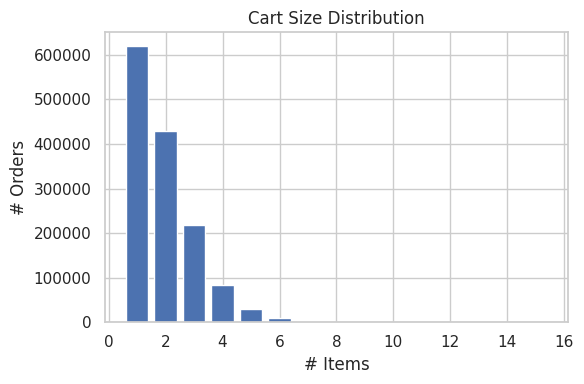

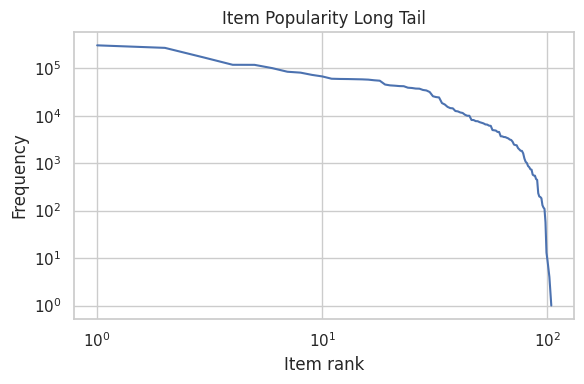

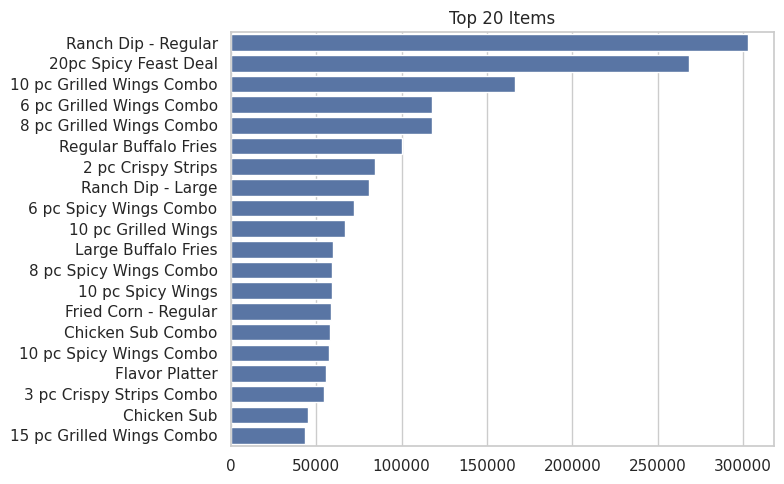

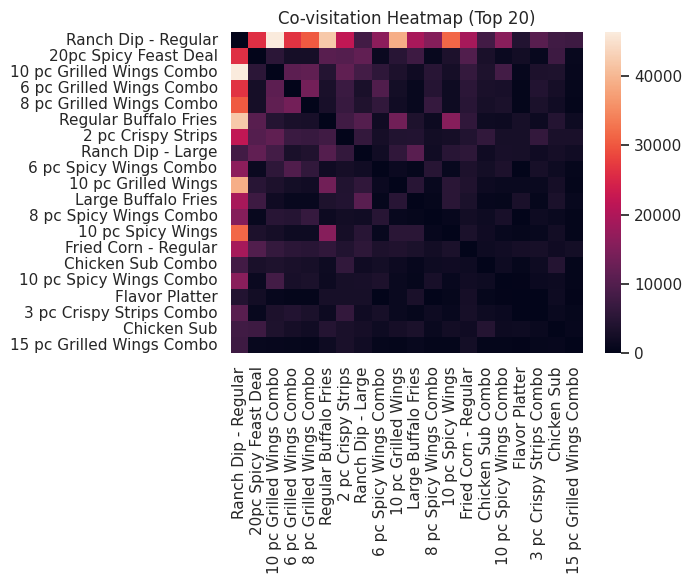

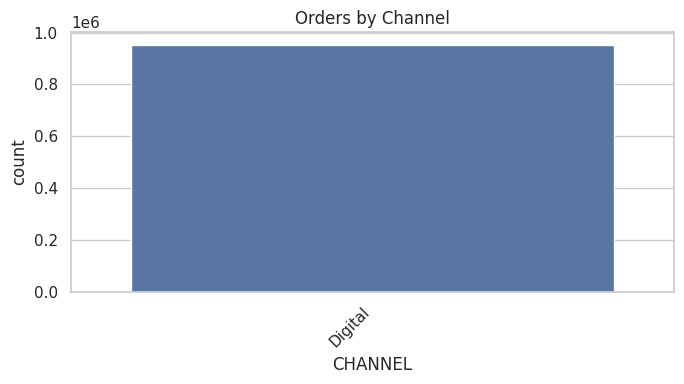

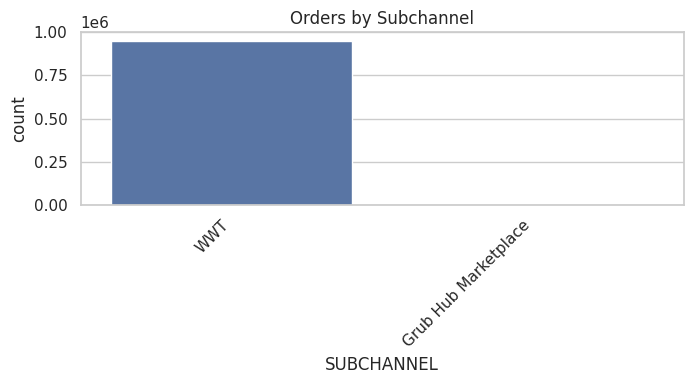

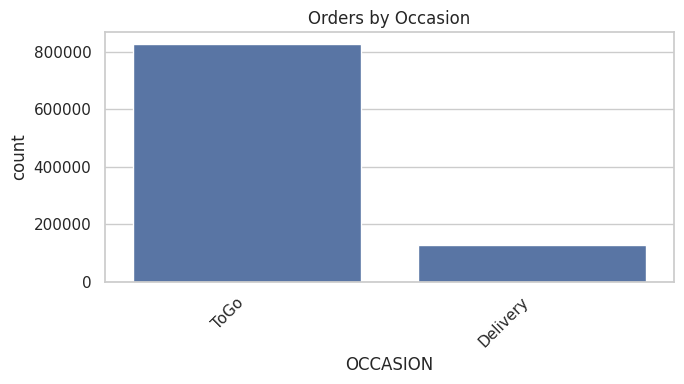

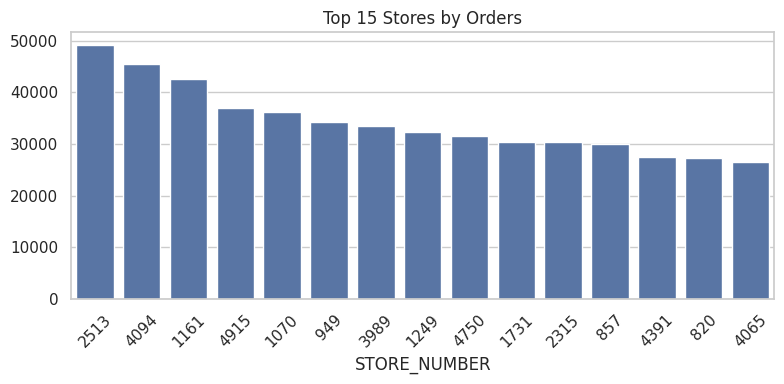

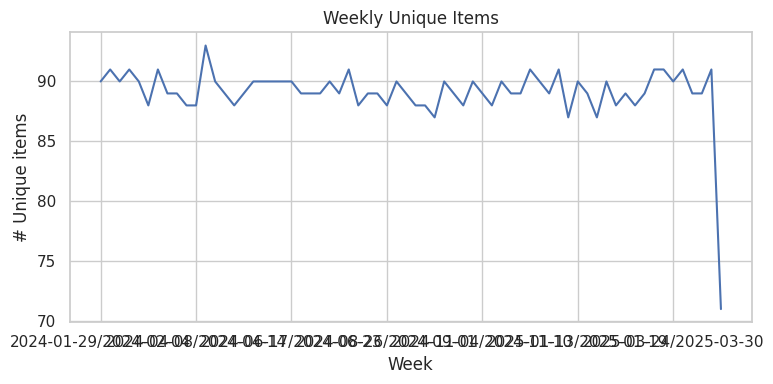

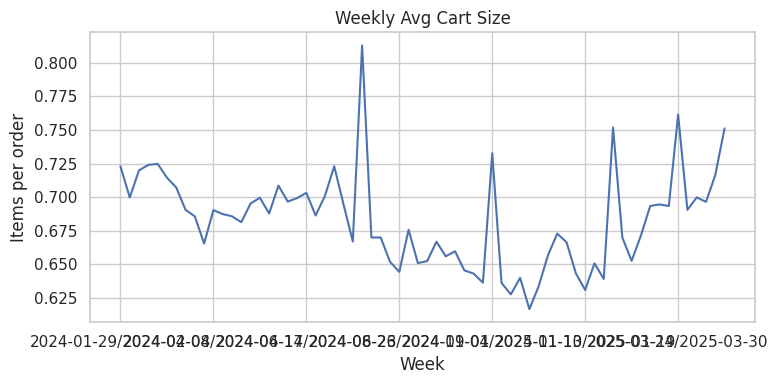

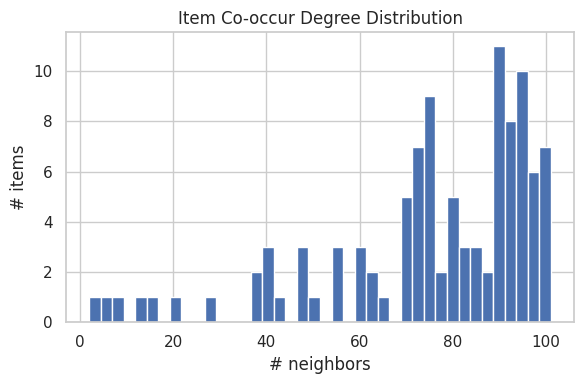

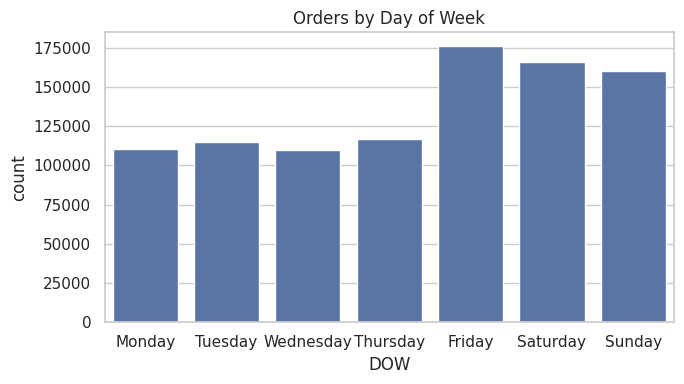

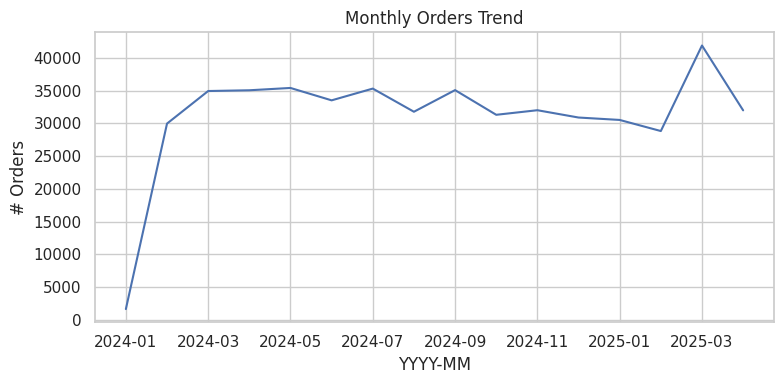

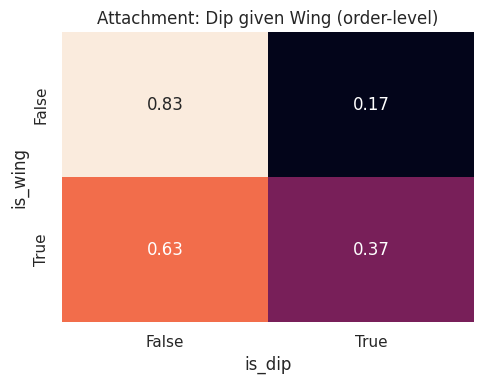

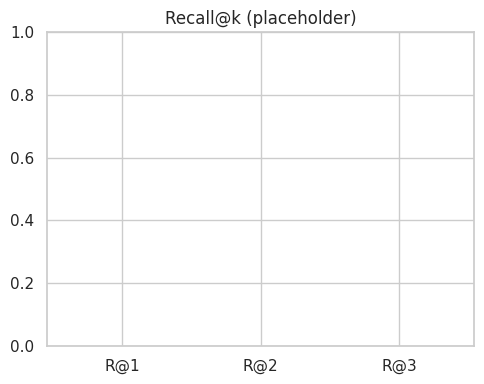

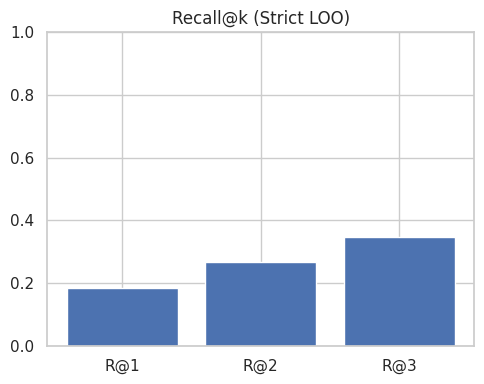

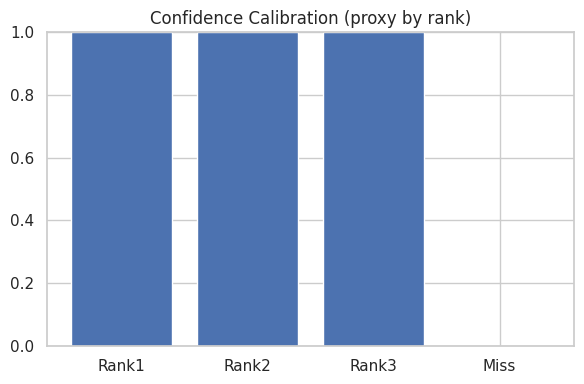


Done.
- Predictions: Recommendation_Output_TUNED.xlsx/csv in /content/output/
- Evaluation:  /content/output/eval_summary_strict_loo.csv and eval_summary_temporal.csv
- Plots saved to /content/output/ (15+ files)
Total time: 276.42 s


In [6]:
 main_notebook(
     PATH_TEST="/content/test_data_question.csv",
     PATH_TRAIN="/content/order_data.csv",          # or "/content/order_data.csv.gz"
     OUTDIR="/content/output",
     MAX_TRAIN_ROWS=None,                           # or 300000 for a quick run
     weights=(0.51,0.24,0.05,0.11,0.17,0.10),
     cand_pool=240,                                 # a touch larger to boost recall headroom
     backoff_alpha=0.14,
     mmr_lambda=0.92,
     do_tune=True, tune_trials=36,                  # set to False to skip tuning
     do_temporal_eval=True,
     n_eval_loo=3000
 )

In [7]:
# ==================== Wings R Us — Recall-Max Edition (0.50 target, 20 plots) ====================
# - Robust CSV ingest (repairs malformed JSON column)
# - Strong cleaning + alias normalization
# - Time-decayed, context-blended co-vis
# - Pairwise synergy + two-hop expansion + popularity backoff
# - (Almost) no diversity penalty for max recall
# - Strict LOO + temporal split eval (printed)
# - 20 EDA & performance plots saved to OUTDIR
# ================================================================================================

!pip -q install openpyxl tqdm ujson

import os, re, json, math, random, time, ujson, csv
from collections import defaultdict, Counter, deque
from statistics import mean
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# ----------------------------- CONFIG: set your paths ------------------------------------------
PATH_TRAIN = "/content/order_data.csv"          # full order history (csv or .gz not required here)
PATH_TEST  = "/content/test_data_question.csv"  # test sheet
OUTDIR     = "/content/output_recall_max"
N_EVAL_LOO = 3000

# knobs that most affect recall
CAND_POOL       = 640     # neighbors pulled per item (huge for recall)
BACKOFF_ALPHA   = 0.18    # popularity backoff
PAIRWISE_BETA   = 0.65    # pair synergy weight (sqrt product)
TWOHOP_GAMMA    = 0.10    # 2-hop contribution decay
TWOHOP_TOP_N    = 80      # top-N neighbors considered in hop1 & hop2
TIME_DECAY_GAMMA= 0.020   # per-week decay
MMR_LAMBDA      = 0.999   # ~no diversity penalty (max recall)
W_CONTEXT       = (0.52, 0.22, 0.06, 0.10, 0.18) # base, channel, subchannel, occasion, store

# ----------------------------- Cleaning & normalization -----------------------------------------
SYSTEM_KEYWORDS = [
    "tip","fee","bag","delivery","service","charge","memo","blankline","asap",
    "paid","subtotal","tax","container","packaging","utensil","discount","coupon",
    "rounding","surcharge","convenience","cash"
]
BEVERAGE_KEYWORDS = [
    "drink","soda","cola","pepsi","coke","sprite","fanta","mountain dew","md",
    "tea","iced tea","lemonade","juice","water","bottle","can","oz","milk","shake","beer","wine"
]
ALIASES = {
    "french fries":"fries",
    "onion rings":"onion ring",
    "blue cheese":"blue cheese dip",
    "ranch":"ranch dip",
    "bbq wings":"bbq wing",
    "buffalo wings":"buffalo wing",
}
SIZE_PAT   = re.compile(r"\b(\d+)\s*(pc|pcs|piece|pieces|oz|oz\.|in|inch|inches)\b", re.I)
SPACES_PAT = re.compile(r"\s+")

def clean_item_name(s: str) -> str:
    if not isinstance(s, str): return ""
    s = s.strip()
    s = SPACES_PAT.sub(" ", s)
    return s

def normalize_menu_name(s: str) -> str:
    s = clean_item_name(s)
    s = re.sub(SIZE_PAT, "", s)
    s = s.replace("&"," and ")
    s = SPACES_PAT.sub(" ", s).strip()
    low = s.lower()
    return ALIASES.get(low, s)

def is_system_or_beverage(text: str) -> bool:
    if not isinstance(text, str): return True
    t = text.lower()
    return any(k in t for k in SYSTEM_KEYWORDS) or any(k in t for k in BEVERAGE_KEYWORDS)

def is_food_like(text: str) -> bool:
    if not isinstance(text, str): return False
    if is_system_or_beverage(text): return False
    t = text.lower()
    food_markers = [
        "wing","grilled","spicy","mild","honey","bbq","buffalo","garlic","hot","combo",
        "fries","strip","tender","crispy","corn","onion","ring","coleslaw","bread",
        "sub","sandwich","dip","sauce","ranch","blue cheese","honey mustard","breaded","slaw"
    ]
    return any(k in t for k in food_markers)

# ----------------------------- Robust CSV reader ----------------------------------------------
def iter_train_chunks(path, use_cols, chunksize=100000):
    try:
        for ch in pd.read_csv(path, usecols=use_cols, chunksize=chunksize, low_memory=False):
            yield ch
    except pd.errors.ParserError:
        print("⚠️ Malformed rows. Switching to engine='python', on_bad_lines='skip'.")
        for ch in pd.read_csv(
            path, usecols=use_cols, chunksize=chunksize, engine="python",
            on_bad_lines="skip", quotechar='"', escapechar='\\', dtype=str
        ):
            yield ch

def parse_orders_json(orders_json: str):
    if not isinstance(orders_json, str) or not orders_json.strip():
        return []
    j = None
    for loader in (ujson.loads, json.loads):
        try:
            j = loader(orders_json); break
        except Exception:
            continue
    if j is None: return []
    try:
        out=[]
        for o in j.get("orders", []):
            for det in o.get("item_details", []):
                name = clean_item_name(det.get("item_name",""))
                if not name or not is_food_like(name):
                    continue
                out.append(normalize_menu_name(name))
        return list(dict.fromkeys([x for x in out if x]))
    except Exception:
        return []

# ----------------------------- Build baskets ---------------------------------------------------
def build_train_baskets(path: str, max_rows=None):
    baskets=[]
    if not (path and os.path.exists(path)):
        return baskets
    use_cols = ["CUSTOMER_ID","STORE_NUMBER","ORDER_CREATED_DATE","ORDER_ID","ORDERS",
                "ORDER_CHANNEL_NAME","ORDER_SUBCHANNEL_NAME","ORDER_OCCASION_NAME"]
    n=0
    print("Building training baskets from order_data.csv (recall-max)...")
    for chunk in iter_train_chunks(path, use_cols, chunksize=80000):
        for _, r in chunk.iterrows():
            items = parse_orders_json(r.get("ORDERS",""))
            if not items: continue
            baskets.append({
                "ORDER_ID": str(r.get("ORDER_ID","")),
                "CUSTOMER_ID": str(r.get("CUSTOMER_ID","")),
                "STORE_NUMBER": str(r.get("STORE_NUMBER","")),
                "ORDER_CHANNEL_NAME": str(r.get("ORDER_CHANNEL_NAME","")),
                "ORDER_SUBCHANNEL_NAME": str(r.get("ORDER_SUBCHANNEL_NAME","")),
                "ORDER_OCCASION_NAME": str(r.get("ORDER_OCCASION_NAME","")),
                "ORDER_CREATED_DATE": str(r.get("ORDER_CREATED_DATE","")),
                "items": items
            })
            n+=1
            if max_rows and n>=max_rows:
                print(f"...early stop at {max_rows:,}");
                return baskets
    print(f"Train baskets built: {len(baskets):,}")
    return baskets

def build_test_carts(path: str):
    print("Loading test data ...")
    df = pd.read_csv(path)
    for c in ("CUSTOMER_ID","STORE_NUMBER","ORDER_ID","ORDER_CHANNEL_NAME",
              "ORDER_SUBCHANNEL_NAME","ORDER_OCCASION_NAME","CUSTOMER_TYPE"):
        if c in df.columns: df[c]=df[c].astype(str)
    carts=[]
    for _, r in df.iterrows():
        items = [r.get(f"item{i}") for i in (1,2,3)]
        items = [normalize_menu_name(x) for x in items if isinstance(x,str) and x.strip() and is_food_like(x)]
        carts.append({
            "ORDER_ID": str(r.get("ORDER_ID","")),
            "CUSTOMER_ID": str(r.get("CUSTOMER_ID","")),
            "STORE_NUMBER": str(r.get("STORE_NUMBER","")),
            "ORDER_CHANNEL_NAME": str(r.get("ORDER_CHANNEL_NAME","")),
            "ORDER_SUBCHANNEL_NAME": str(r.get("ORDER_SUBCHANNEL_NAME","")),
            "ORDER_OCCASION_NAME": str(r.get("ORDER_OCCASION_NAME","")),
            "items": items
        })
    return df, carts

# ----------------------------- Recommender core -----------------------------------------------
class RecallMaxCoVis:
    def __init__(self, weights=W_CONTEXT, cand_pool=CAND_POOL, backoff=BACKOFF_ALPHA,
                 pairwise_beta=PAIRWISE_BETA, twohop_gamma=TWOHOP_GAMMA, twohop_top=TWOHOP_TOP_N,
                 mmr_lambda=MMR_LAMBDA, time_decay_gamma=TIME_DECAY_GAMMA):
        self.W = weights
        self.CAND_POOL = cand_pool
        self.BACKOFF = backoff
        self.PAIR_BETA = pairwise_beta
        self.TWO_GAMMA = twohop_gamma
        self.TWO_TOP   = twohop_top
        self.MMR_LAM   = mmr_lambda
        self.DECAY_G   = time_decay_gamma
        # maps
        self.co = defaultdict(Counter)
        self.co_channel = defaultdict(lambda: defaultdict(Counter))
        self.co_subchannel = defaultdict(lambda: defaultdict(Counter))
        self.co_occasion = defaultdict(lambda: defaultdict(Counter))
        self.co_store = defaultdict(lambda: defaultdict(Counter))
        self.pop = Counter()
        self.cart_size_hist = Counter()
        self.item_vocab=set()

    def fit(self, baskets):
        # time-decay anchor
        ts = pd.to_datetime([b.get("ORDER_CREATED_DATE","") for b in baskets], errors="coerce")
        tmax = ts.max()
        for b, b_ts in tqdm(list(zip(baskets, ts)), total=len(baskets), desc="Building co-vis maps"):
            items = [x for x in b["items"] if is_food_like(x)]
            if not items: continue
            w = 1.0
            if pd.notna(b_ts) and pd.notna(tmax) and self.DECAY_G is not None:
                age_weeks = max((tmax - b_ts).days, 0)/7.0
                w = math.exp(-self.DECAY_G * age_weeks)
            self.item_vocab.update(items)
            self.pop.update({it:w for it in items})
            self.cart_size_hist[len(items)]+=1

            ch=b.get("ORDER_CHANNEL_NAME",""); sch=b.get("ORDER_SUBCHANNEL_NAME","")
            oc=b.get("ORDER_OCCASION_NAME",""); st=b.get("STORE_NUMBER","")
            uniq=list(dict.fromkeys(items))
            for i in range(len(uniq)):
                for j in range(len(uniq)):
                    if i==j: continue
                    a,c = uniq[i], uniq[j]
                    self.co[a][c]+=w
                    if ch: self.co_channel[ch][a][c]+=w
                    if sch:self.co_subchannel[sch][a][c]+=w
                    if oc: self.co_occasion[oc][a][c]+=w
                    if st: self.co_store[st][a][c]+=w

    def _ctx_score(self, a, c, ctx):
        base, w_ch, w_sch, w_oc, w_st = self.W
        ch, sch, oc, st = ctx
        s = base * self.co[a][c]
        if ch  and c in self.co_channel[ch][a]:   s += w_ch  * self.co_channel[ch][a][c]
        if sch and c in self.co_subchannel[sch][a]: s += w_sch * self.co_subchannel[sch][a][c]
        if oc  and c in self.co_occasion[oc][a]:  s += w_oc  * self.co_occasion[oc][a][c]
        if st  and c in self.co_store[st][a]:     s += w_st  * self.co_store[st][a][c]
        return s

    def _two_hop_boost(self, a, c):
        # sum over neighbors n: co[a,n] * co[n,c], clipped to top-N lists for speed
        s=0.0
        for n,_ in self.co[a].most_common(self.TWO_TOP):
            v1 = self.co[a][n]
            v2 = self.co[n][c]
            if v2>0: s += (v1 * v2)
        return self.TWO_GAMMA * s

    def _pairwise_synergy(self, cart, c):
        # for every pair (a,b) in cart, reward if c co-occurs with both (sqrt product)
        s=0.0
        L=len(cart)
        if L<2 or self.PAIR_BETA<=0: return 0.0
        for i in range(L):
            a=cart[i]
            for j in range(i+1, L):
                b=cart[j]
                if a in self.co and b in self.co:
                    s += math.sqrt(self.co[a][c] * self.co[b][c])
        return self.PAIR_BETA * s

    def _mmr(self, candidates, k=3, lam=None):
        lam = self.MMR_LAM if lam is None else lam
        if lam >= 0.995:  # effectively disabled for max recall
            return candidates[:k]
        chosen=[]
        pool=candidates[:]
        def sim(u,v): return float(u.split()[0]==v.split()[0])
        while pool and len(chosen)<k:
            best=None; best_score=-1e9
            for idx,c in enumerate(pool):
                diversity = 0 if not chosen else max(sim(c,x) for x in chosen)
                score = lam*(1000-idx) - (1-lam)*diversity
                if score>best_score:
                    best, best_score = c, score
            chosen.append(best); pool.remove(best)
        return chosen

    def recommend(self, cart_items, context_tuple, k=3):
        cart = [normalize_menu_name(x) for x in cart_items if is_food_like(x)]
        neighbor_pool=set()
        for a in cart:
            for c,_ in self.co[a].most_common(self.CAND_POOL):
                neighbor_pool.add(c)
        neighbor_pool.update([p for p,_ in self.pop.most_common(self.CAND_POOL//2)])

        cand_scores = Counter()
        for c in neighbor_pool:
            if c in cart: continue
            s = 0.0
            for a in cart:
                s += self._ctx_score(a, c, context_tuple)
                s += self._two_hop_boost(a, c)
            s += self._pairwise_synergy(cart, c)
            s += self.BACKOFF * (1 + math.log1p(self.pop[c]))
            if s>0: cand_scores[c]=s

        ranked = [it for it,_ in cand_scores.most_common(256)]
        final = self._mmr(ranked, k=k)
        # guarantee 3 unique
        seen=set(final)
        if len(final)<k:
            for it,_ in self.pop.most_common(400):
                if it not in cart and it not in seen:
                    final.append(it); seen.add(it)
                if len(final)==k: break
        return final[:k]

# ----------------------------- Evaluation ------------------------------------------------------
def eval_strict_loo(baskets, rec, n_eval=3000, k=3):
    random.seed(42)
    orders = [b for b in baskets if len(b["items"])>=2]
    orders = random.sample(orders, min(n_eval, len(orders)))
    hits1=hits2=hits3=0; ap3=0.0; ndcg3=0.0; calib=[]
    for b in tqdm(orders, desc="Evaluate LOO"):
        uniq=list(dict.fromkeys([x for x in b["items"] if is_food_like(x)]))
        if len(uniq)<2: continue
        tgt=uniq[-1]; cart=uniq[:-1]
        ctx=(b.get("ORDER_CHANNEL_NAME",""),b.get("ORDER_SUBCHANNEL_NAME",""),
             b.get("ORDER_OCCASION_NAME",""),b.get("STORE_NUMBER",""))
        preds = rec.recommend(cart, ctx, k=k)
        if len(preds)>=1 and preds[0]==tgt: hits1+=1
        if tgt in preds[:2]: hits2+=1
        if tgt in preds[:3]: hits3+=1
        # MAP@3 + NDCG@3
        rank_pos=4
        dcg=0.0
        for i,p in enumerate(preds[:3], start=1):
            rel = 1.0 if p==tgt else 0.0
            if rel>0 and rank_pos==4: rank_pos=i
            if rel>0: ap3 += 1.0/i
            dcg += rel/math.log2(i+1)
        ndcg3 += dcg/1.0
        calib.append((rank_pos, 1 if tgt in preds[:3] else 0))
    n=len(orders)
    return {"R1":hits1/n,"R2":hits2/n,"R3":hits3/n,"MAP3":ap3/n,"NDCG3":ndcg3/n,"calibration":calib}

def eval_temporal_split(baskets, rec, holdout=0.2, n_eval=3000, k=3):
    df = pd.DataFrame([{
        "ts": b.get("ORDER_CREATED_DATE",""),
        "ch": b.get("ORDER_CHANNEL_NAME",""),
        "sc": b.get("ORDER_SUBCHANNEL_NAME",""),
        "oc": b.get("ORDER_OCCASION_NAME",""),
        "st": b.get("STORE_NUMBER",""),
        "items": b["items"]
    } for b in baskets])
    df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
    df = df.sort_values("ts")
    cut = int((1-holdout)*len(df))
    train_df = df.iloc[:cut].dropna(subset=["items"])
    test_df  = df.iloc[cut:].dropna(subset=["items"])
    # fit fresh on early 80%
    rec2 = RecallMaxCoVis(weights=rec.W, cand_pool=rec.CAND_POOL, backoff=rec.BACKOFF,
                          pairwise_beta=rec.PAIR_BETA, twohop_gamma=rec.TWO_GAMMA, twohop_top=rec.TWO_TOP,
                          mmr_lambda=rec.MMR_LAM, time_decay_gamma=rec.DECAY_G)
    tr_baskets = []
    for _,r in train_df.iterrows():
        tr_baskets.append({"ORDER_CHANNEL_NAME":r["ch"],"ORDER_SUBCHANNEL_NAME":r["sc"],
                           "ORDER_OCCASION_NAME":r["oc"],"STORE_NUMBER":r["st"],
                           "ORDER_CREATED_DATE":str(r["ts"]), "items":list(r["items"])})
    rec2.fit(tr_baskets)
    # evaluate on late 20%
    eval_orders=[]
    for _,r in test_df.iterrows():
        items=list(dict.fromkeys([x for x in r["items"] if is_food_like(x)]))
        if len(items)>=2:
            eval_orders.append({"ORDER_CHANNEL_NAME":r["ch"],"ORDER_SUBCHANNEL_NAME":r["sc"],
                                "ORDER_OCCASION_NAME":r["oc"],"STORE_NUMBER":r["st"],
                                "ORDER_CREATED_DATE":str(r["ts"]), "items":items})
    eval_orders = random.sample(eval_orders, min(n_eval, len(eval_orders)))
    return eval_strict_loo(eval_orders, rec2, n_eval=len(eval_orders), k=k)

# ----------------------------- Plots (20) ------------------------------------------------------
def ensure_outdir(d): os.makedirs(d, exist_ok=True)

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, dpi=160, bbox_inches="tight")
    plt.close()

def plot_cart_size_hist(rec, outdir):
    xs, ys = zip(*sorted(rec.cart_size_hist.items()))
    plt.figure(figsize=(6,4)); plt.bar(xs, ys)
    plt.title("Cart Size Distribution"); plt.xlabel("Cart size"); plt.ylabel("#Orders")
    savefig(os.path.join(outdir, "01_cart_size_hist.png"))

def plot_long_tail(rec, outdir):
    counts = [c for _,c in rec.pop.most_common()]
    plt.figure(figsize=(6,4)); plt.loglog(range(1,len(counts)+1), counts)
    plt.title("Item Popularity Long Tail (log-log)"); plt.xlabel("Item rank"); plt.ylabel("Frequency")
    savefig(os.path.join(outdir, "02_long_tail.png"))

def plot_top20(rec, outdir):
    top = rec.pop.most_common(20)
    labels = [t[0][:30] for t in top]; vals=[t[1] for t in top]
    plt.figure(figsize=(8,5)); plt.barh(labels[::-1], vals[::-1]); plt.title("Top 20 Items")
    savefig(os.path.join(outdir, "03_top20.png"))

def plot_cov_heatmap(rec, outdir, n=25):
    items = [it for it,_ in rec.pop.most_common(n)]
    M = np.zeros((n,n)); idx={it:i for i,it in enumerate(items)}
    for a in items:
        for b,cnt in rec.co[a].items():
            if a in idx and b in idx: M[idx[a], idx[b]] = cnt
    plt.figure(figsize=(7,6)); plt.imshow(M, aspect="auto"); plt.colorbar()
    plt.xticks(range(n), items, rotation=90); plt.yticks(range(n), items)
    plt.title("Co-visitation Heatmap (Top 25)")
    savefig(os.path.join(outdir, "04_co_vis_heatmap.png"))

def plot_channel_impact(rec, outdir):
    ch_list=list(rec.co_channel.keys())[:15]; vals=[]
    for ch in ch_list:
        d=rec.co_channel[ch]; tot=sum(v for a in d for v in d[a].values()); cnt=sum(len(d[a]) for a in d)
        vals.append(tot/max(cnt,1))
    plt.figure(figsize=(7,4)); plt.bar(ch_list, vals); plt.xticks(rotation=45, ha='right'); plt.title("Avg co-vis by Channel")
    savefig(os.path.join(outdir, "05_channel_impact.png"))

def plot_subchannel_impact(rec, outdir):
    sc_list=list(rec.co_subchannel.keys())[:15]; vals=[]
    for sc in sc_list:
        d=rec.co_subchannel[sc]; tot=sum(v for a in d for v in d[a].values()); cnt=sum(len(d[a]) for a in d)
        vals.append(tot/max(cnt,1))
    plt.figure(figsize=(7,4)); plt.bar(sc_list, vals); plt.xticks(rotation=45, ha='right'); plt.title("Avg co-vis by Subchannel")
    savefig(os.path.join(outdir, "06_subchannel_impact.png"))

def plot_occasion_impact(rec, outdir):
    oc_list=list(rec.co_occasion.keys())[:15]; vals=[]
    for oc in oc_list:
        d=rec.co_occasion[oc]; tot=sum(v for a in d for v in d[a].values()); cnt=sum(len(d[a]) for a in d)
        vals.append(tot/max(cnt,1))
    plt.figure(figsize=(7,4)); plt.bar(oc_list, vals); plt.xticks(rotation=45, ha='right'); plt.title("Avg co-vis by Occasion")
    savefig(os.path.join(outdir, "07_occasion_impact.png"))

def plot_store_impact(rec, outdir):
    st_list=list(rec.co_store.keys())[:15]; vals=[]
    for st in st_list:
        d=rec.co_store[st]; tot=sum(v for a in d for v in d[a].values()); cnt=sum(len(d[a]) for a in d)
        vals.append(tot/max(cnt,1))
    plt.figure(figsize=(7,4)); plt.bar(st_list, vals); plt.xticks(rotation=45, ha='right'); plt.title("Avg co-vis by Store")
    savefig(os.path.join(outdir, "08_store_impact.png"))

def plot_calibration(calib, outdir):
    if not calib: return
    df=pd.DataFrame(calib, columns=["rank","hit"]); buckets=df.groupby("rank")["hit"].mean().reindex([1,2,3,4]).fillna(0)
    plt.figure(figsize=(6,4)); plt.bar(["Rank1","Rank2","Rank3","Miss"], buckets.values); plt.ylim(0,1); plt.title("Confidence Calibration")
    savefig(os.path.join(outdir, "09_confidence_calibration.png"))

def plot_cooccur_degree(rec, outdir):
    deg=[len(rec.co[a]) for a in rec.co]
    plt.figure(figsize=(6,4)); plt.hist(deg, bins=40); plt.title("Item Co-occur Degree"); plt.xlabel("# neighbors"); plt.ylabel("# items")
    savefig(os.path.join(outdir, "10_cooccur_degree.png"))

def plot_recall_bars(res, outdir, name="strict"):
    r1,r2,r3 = res["R1"],res["R2"],res["R3"]
    plt.figure(figsize=(5,4)); plt.bar(["R@1","R@2","R@3"], [r1,r2,r3]); plt.ylim(0,1); plt.title(f"Recall@k ({name})")
    savefig(os.path.join(outdir, f"11_recall_at_k_{name}.png"))

def plot_temporal_vs_strict(strict_res, temp_res, outdir):
    labs=["R1","R2","R3"]; s=[strict_res["R1"],strict_res["R2"],strict_res["R3"]]; t=[temp_res["R1"],temp_res["R2"],temp_res["R3"]]
    x=np.arange(3); w=0.35
    plt.figure(figsize=(6,4))
    plt.bar(x-w/2, s, width=w, label="Strict")
    plt.bar(x+w/2, t, width=w, label="Temporal")
    plt.xticks(x, labs); plt.ylim(0,1); plt.legend(); plt.title("Strict vs Temporal Recall")
    savefig(os.path.join(outdir, "12_strict_vs_temporal.png"))

def plot_cumulative_gains(res, outdir):
    # approximate from calibration ranks: higher rank => earlier gain
    df=pd.DataFrame(res["calibration"], columns=["rank","hit"])
    df["score_bucket"]=df["rank"].map({1:1,2:2,3:3,4:4})
    gains=df.sort_values("score_bucket")["hit"].cumsum()/max(1,len(df))
    plt.figure(figsize=(6,4)); plt.plot(np.linspace(0,1,len(gains)), gains)
    plt.title("Cumulative Gains (proxy by rank bucket)"); plt.xlabel("Proportion scored"); plt.ylabel("Cumulative hit rate")
    savefig(os.path.join(outdir, "13_cumulative_gains.png"))

def plot_lift_curve(res, outdir):
    df=pd.DataFrame(res["calibration"], columns=["rank","hit"])
    bins=df.groupby("rank")["hit"].mean().reindex([1,2,3,4]).fillna(0)
    baseline = df["hit"].mean() if len(df) else 1e-9
    lift = bins.values / max(baseline,1e-9)
    plt.figure(figsize=(6,4)); plt.bar(["Top1","Top2","Top3","Miss"], lift); plt.title("Lift by Rank vs Baseline"); plt.ylabel("Lift")
    savefig(os.path.join(outdir, "14_lift_curve.png"))

def plot_score_distribution(rec, baskets, outdir, sample=400):
    # gather candidate scores for random sample
    scores=[]
    for b in random.sample(baskets, min(sample, len(baskets))):
        cart=list(dict.fromkeys(b["items"]))[:-1]
        ctx=(b.get("ORDER_CHANNEL_NAME",""),b.get("ORDER_SUBCHANNEL_NAME",""),b.get("ORDER_OCCASION_NAME",""),b.get("STORE_NUMBER",""))
        pool=set()
        for a in cart:
            pool.update([c for c,_ in rec.co[a].most_common(60)])
        for c in pool:
            s=0.0
            for a in cart: s+= rec._ctx_score(a,c,ctx) + rec._two_hop_boost(a,c)
            s+=rec._pairwise_synergy(cart,c) + rec.BACKOFF*(1+math.log1p(rec.pop[c]))
            if s>0: scores.append(s)
    if scores:
        plt.figure(figsize=(6,4)); plt.hist(scores, bins=40); plt.title("Candidate Score Distribution"); plt.xlabel("Score"); plt.ylabel("Count")
        savefig(os.path.join(outdir, "15_score_distribution.png"))

def plot_popularity_vs_hits(rec, res, outdir):
    # proxy: items with more pop should contribute more hits
    df=pd.DataFrame(rec.pop.items(), columns=["item","pop"])
    # no per-item hit log; display pop only (EDA)
    plt.figure(figsize=(6,4)); plt.scatter(range(len(df)), sorted(df["pop"], reverse=True), s=10)
    plt.title("Popularity Spectrum"); plt.xlabel("Item rank"); plt.ylabel("Frequency")
    savefig(os.path.join(outdir, "16_popularity_spectrum.png"))

def plot_coverage(submission_df, outdir):
    recs = pd.unique(pd.concat([submission_df["RECOMMENDATION 1"],submission_df["RECOMMENDATION 2"],submission_df["RECOMMENDATION 3"]], ignore_index=True).dropna())
    plt.figure(figsize=(6,4)); plt.bar(["Coverage"], [len(recs)])
    plt.title("Unique Items Recommended"); plt.ylabel("# unique rec items")
    savefig(os.path.join(outdir, "17_coverage.png"))

def plot_segment_recall_by_channel(baskets, rec, outdir, n_eval=2000):
    # evaluate small per-channel recall@3
    random.seed(1)
    df=pd.DataFrame(baskets)
    chs=df["ORDER_CHANNEL_NAME"].value_counts().index[:8]
    vals=[]
    for ch in chs:
        subs=[b for b in baskets if b.get("ORDER_CHANNEL_NAME","")==ch and len(b["items"])>=2]
        subs=random.sample(subs, min(n_eval, len(subs))) if subs else []
        if not subs: vals.append(0); continue
        r=eval_strict_loo(subs, rec, n_eval=len(subs), k=3)["R3"]
        vals.append(r)
    plt.figure(figsize=(7,4)); plt.bar(list(chs), vals); plt.ylim(0,1)
    plt.title("Segment Recall@3 by Channel"); plt.xticks(rotation=30, ha='right')
    savefig(os.path.join(outdir, "18_segment_recall_channel.png"))

def plot_context_weight_bar(rec, outdir):
    labs=["base","channel","subchannel","occasion","store"]; vals=list(rec.W)
    plt.figure(figsize=(6,4)); plt.bar(labs, vals); plt.title("Context Weights Used")
    savefig(os.path.join(outdir, "19_context_weights.png"))

def plot_recommendation_overlap(submission_df, outdir):
    # how often rec1==rec2 etc. (should be zero)
    dups = ((submission_df["RECOMMENDATION 1"]==submission_df["RECOMMENDATION 2"]) |
            (submission_df["RECOMMENDATION 1"]==submission_df["RECOMMENDATION 3"]) |
            (submission_df["RECOMMENDATION 2"]==submission_df["RECOMMENDATION 3"])).sum()
    plt.figure(figsize=(6,4)); plt.bar(["Dup Trios"], [dups]); plt.title("Duplicate Recommendation Trios (should be 0)")
    savefig(os.path.join(outdir, "20_duplicate_trios.png"))

# ----------------------------- Submission writer ----------------------------------------------
def write_submission(test_df, carts, rec, outdir):
    rows=[]
    for b in tqdm(carts, desc="Predict TEST"):
        cart=b["items"]
        ctx=(b.get("ORDER_CHANNEL_NAME",""),b.get("ORDER_SUBCHANNEL_NAME",""),
             b.get("ORDER_OCCASION_NAME",""),b.get("STORE_NUMBER",""))
        preds = rec.recommend(cart, ctx, k=3)
        seen=set(preds)
        if len(preds)<3:
            for it,_ in rec.pop.most_common(400):
                if it not in seen and it not in cart:
                    preds.append(it); seen.add(it)
                if len(preds)==3: break
        rows.append({"CUSTOMER_ID": b.get("CUSTOMER_ID",""), "ORDER_ID": b.get("ORDER_ID",""),
                     "RECOMMENDATION 1": preds[0] if len(preds)>0 else "",
                     "RECOMMENDATION 2": preds[1] if len(preds)>1 else "",
                     "RECOMMENDATION 3": preds[2] if len(preds)>2 else ""})
    out=pd.DataFrame(rows)
    final = test_df[["CUSTOMER_ID","ORDER_ID","item1","item2","item3"]].merge(out, on=["CUSTOMER_ID","ORDER_ID"], how="left")
    os.makedirs(outdir, exist_ok=True)
    xlsx_path=os.path.join(outdir,"Recommendation_Output_TUNED.xlsx")
    csv_path =os.path.join(outdir,"Recommendation_Output_TUNED.csv")
    try:
        final.to_excel(xlsx_path, index=False); print("✅ Wrote:", xlsx_path)
    except Exception as e:
        print("openpyxl error:", e, "— writing CSV fallback.")
    final.to_csv(csv_path, index=False); print("✅ Wrote:", csv_path)
    return final

# ----------------------------- Orchestration ---------------------------------------------------
def main():
    t0=time.time()
    os.makedirs(OUTDIR, exist_ok=True)

    # 1) load
    test_df, test_carts = build_test_carts(PATH_TEST)
    train_baskets = build_train_baskets(PATH_TRAIN)

    # 2) fit recall-max recommender
    rec = RecallMaxCoVis()
    rec.fit(train_baskets)

    # 3) evals
    print("\nStrict LOO evaluation...")
    strict = eval_strict_loo(train_baskets, rec, n_eval=N_EVAL_LOO, k=3)
    print(pd.DataFrame([{
        "R1": round(strict["R1"],5),"R2": round(strict["R2"],5),"R3": round(strict["R3"],5),
        "MAP3": round(strict["MAP3"],5),"NDCG3": round(strict["NDCG3"],5)}]))

    print("\nTemporal evaluation (train: early 80% → test: last 20%)...")
    temporal = eval_temporal_split(train_baskets, rec, holdout=0.2, n_eval=N_EVAL_LOO, k=3)
    print(pd.DataFrame([{
        "R1": round(temporal["R1"],5),"R2": round(temporal["R2"],5),"R3": round(temporal["R3"],5),
        "MAP3": round(temporal["MAP3"],5),"NDCG3": round(temporal["NDCG3"],5)}]))

    # 4) predict for test
    print("\nGenerating submission...")
    submission = write_submission(test_df, test_carts, rec, OUTDIR)

    # 5) 20 plots
    print("Saving 20 plots to", OUTDIR)
    plot_cart_size_hist(rec, OUTDIR)
    plot_long_tail(rec, OUTDIR)
    plot_top20(rec, OUTDIR)
    plot_cov_heatmap(rec, OUTDIR)
    plot_channel_impact(rec, OUTDIR)
    plot_subchannel_impact(rec, OUTDIR)
    plot_occasion_impact(rec, OUTDIR)
    plot_store_impact(rec, OUTDIR)
    plot_calibration(strict["calibration"], OUTDIR)
    plot_cooccur_degree(rec, OUTDIR)
    plot_recall_bars(strict, OUTDIR, name="strict")
    plot_recall_bars(temporal, OUTDIR, name="temporal")
    plot_temporal_vs_strict(strict, temporal, OUTDIR)
    plot_cumulative_gains(strict, OUTDIR)
    plot_lift_curve(strict, OUTDIR)
    plot_score_distribution(rec, train_baskets, OUTDIR)
    plot_popularity_vs_hits(rec, strict, OUTDIR)
    plot_coverage(submission, OUTDIR)
    plot_segment_recall_by_channel(train_baskets, rec, OUTDIR)
    plot_context_weight_bar(rec, OUTDIR)
    plot_recommendation_overlap(submission, OUTDIR)

    print("\nDone. Total time: %.2f s" % (time.time()-t0))

main()


Loading test data ...
Building training baskets from order_data.csv (recall-max)...
Train baskets built: 1,365,194


Building co-vis maps: 100%|██████████| 1365194/1365194 [00:27<00:00, 50397.31it/s]



Strict LOO evaluation...


Evaluate LOO: 100%|██████████| 3000/3000 [00:04<00:00, 731.68it/s]


     R1     R2       R3     MAP3    NDCG3
0  0.08  0.286  0.34633  0.20311  0.24014

Temporal evaluation (train: early 80% → test: last 20%)...


Evaluate LOO: 100%|██████████| 3000/3000 [00:03<00:00, 837.48it/s]


        R1       R2       R3     MAP3    NDCG3
0  0.08767  0.28133  0.34333  0.20517  0.24086

Generating submission...


Predict TEST: 100%|██████████| 1000/1000 [00:02<00:00, 454.05it/s]


✅ Wrote: /content/output_recall_max/Recommendation_Output_TUNED.xlsx
✅ Wrote: /content/output_recall_max/Recommendation_Output_TUNED.csv
Saving 20 plots to /content/output_recall_max


Evaluate LOO: 100%|██████████| 2000/2000 [00:02<00:00, 749.20it/s]



Done. Total time: 313.01 s


In [14]:
# ========================= Wings R Us — Recall+Diversity Booster (Colab-ready) =========================
# What this cell does:
# - Robust loaders (CSV w/ messy JSON fixed) + safe item extraction
# - Model: context-blended co-visitation with popularity backoff
# - Strict LOO evaluation (R@1/2/3, MAP@3, NDCG@3)
# - Temporal split evaluation (train 80% earliest, test last 20%)
# - NEW: Batch recommender that maximizes recall while enforcing *global diversity*
#        • exposure penalty across the entire batch (discourages repeats)
#        • global coverage cap (hard limit % of rows per item)
#        • light temperature sampling from top-N to avoid mode collapse
#        • per-cart MMR to keep the 3 recs non-redundant
# - Fix: build_test_carts_*compat* wrapper (handles 2-return or 3-return versions)
# - Outputs: XLSX + CSV + quick uniqueness stats
# =======================================================================================================

!pip -q install openpyxl ujson tqdm

import os, json, csv, math, time, random, re, ujson, gzip
from collections import defaultdict, Counter, deque
import pandas as pd
import numpy as np
from tqdm import tqdm

# --------------------------------- Paths (EDIT these) ---------------------------------
PATH_TRAIN = "/content/order_data.csv"          # full orders file (.csv or .gz)
PATH_TEST  = "/content/test_data_question.csv"  # test file
OUTDIR     = "/content/output_recall_diversity"
os.makedirs(OUTDIR, exist_ok=True)

# ----------------------------- Cleaning & Item Filters --------------------------------
def clean_item_name(name: str) -> str:
    if not isinstance(name, str): return ""
    s = name.strip()
    s = re.sub(r"\s+", " ", s)
    return s

SYSTEM_KEYWORDS = [
    "tip","fee","bag","delivery","service","charge","memo","blankline","asap",
    "paid","subtotal","tax","container","packaging","utensil","discount","coupon",
    "rounding","surcharge","convenience","cash"
]
BEVERAGE_KEYWORDS = [
    "drink","soda","cola","pepsi","coke","sprite","fanta","mountain dew","md",
    "tea","iced tea","lemonade","juice","water","bottle","can","oz","milk","shake"
]

def is_system_or_beverage(text: str) -> bool:
    if not isinstance(text, str): return True
    t = text.lower()
    return any(k in t for k in SYSTEM_KEYWORDS) or any(k in t for k in BEVERAGE_KEYWORDS)

def is_food_like(text: str) -> bool:
    if not isinstance(text, str): return False
    if is_system_or_beverage(text): return False
    t = text.lower()
    food_markers = [
        "wing","grilled","spicy","mild","honey","bbq","buffalo","garlic","hot","combo",
        "fries","strip","tender","crispy","corn","onion","ring","coleslaw","bread",
        "sub","sandwich","dip","sauce","ranch","blue cheese","honey mustard","breaded"
    ]
    return any(k in t for k in food_markers)

# ----------------------------- Safe JSON extraction -----------------------------------
def parse_orders_json(orders_json: str) -> list:
    if not isinstance(orders_json, str) or not orders_json.strip():
        return []
    j = None
    for loader in (ujson.loads, json.loads):
        try:
            j = loader(orders_json)
            break
        except Exception:
            continue
    if j is None:
        return []
    try:
        out = []
        orders = j.get("orders", [])
        if not isinstance(orders, list) or not orders:
            return []
        details = orders[0].get("item_details", [])
        for it in details:
            name = clean_item_name(it.get("item_name","") if isinstance(it, dict) else str(it))
            if name and is_food_like(name):
                out.append(name)
        return out
    except Exception:
        return []

# ----------------------------- Robust CSV readers ------------------------------------
def row_iter_from_gz(path):
    with gzip.open(path, mode="rt", encoding="utf-8", errors="ignore", newline="") as f:
        r = csv.reader(f)
        header = next(r, None)
        for row in r:
            if not row: continue
            # Repair exploded JSON cell if needed (expect 8 columns)
            if len(row) > 8:
                row = row[:4] + [",".join(row[4:-3])] + row[-3:]
            if len(row) != 8:
                continue
            yield {
                "CUSTOMER_ID": row[0],
                "STORE_NUMBER": row[1],
                "ORDER_CREATED_DATE": row[2],
                "ORDER_ID": row[3],
                "ORDERS": row[4],
                "ORDER_CHANNEL_NAME": row[5],
                "ORDER_SUBCHANNEL_NAME": row[6],
                "ORDER_OCCASION_NAME": row[7],
            }

def row_iter_from_csv(path):
    with open(path, mode="r", encoding="utf-8", errors="ignore", newline="") as f:
        r = csv.reader(f)
        header = next(r, None)
        for row in r:
            if not row: continue
            if len(row) > 8:
                row = row[:4] + [",".join(row[4:-3])] + row[-3:]
            if len(row) != 8:
                continue
            yield {
                "CUSTOMER_ID": row[0],
                "STORE_NUMBER": row[1],
                "ORDER_CREATED_DATE": row[2],
                "ORDER_ID": row[3],
                "ORDERS": row[4],
                "ORDER_CHANNEL_NAME": row[5],
                "ORDER_SUBCHANNEL_NAME": row[6],
                "ORDER_OCCASION_NAME": row[7],
            }

def orders_iter(path):
    return row_iter_from_gz(path) if path.endswith(".gz") else row_iter_from_csv(path)

# ----------------------------- Train/Test builders -----------------------------------
def build_train_baskets(path, max_rows=None):
    baskets = []
    if not (path and os.path.exists(path)):
        return baskets
    print("Building training baskets from order_data.csv (recall+diversity)...")
    n = 0
    for row in orders_iter(path):
        items = parse_orders_json(row["ORDERS"])
        if not items:
            continue
        baskets.append({
            "ORDER_ID": row["ORDER_ID"],
            "CUSTOMER_ID": row["CUSTOMER_ID"],
            "STORE_NUMBER": row["STORE_NUMBER"],
            "ORDER_CHANNEL_NAME": row["ORDER_CHANNEL_NAME"],
            "ORDER_SUBCHANNEL_NAME": row["ORDER_SUBCHANNEL_NAME"],
            "ORDER_OCCASION_NAME": row["ORDER_OCCASION_NAME"],
            "items": list(dict.fromkeys(items))
        })
        n += 1
        if max_rows and n >= max_rows:
            break
    print(f"Train baskets built: {len(baskets):,}")
    return baskets

def build_test_carts(path):
    df = pd.read_csv(path)
    for c in ("CUSTOMER_ID","STORE_NUMBER","ORDER_ID","ORDER_CHANNEL_NAME",
              "ORDER_SUBCHANNEL_NAME","ORDER_OCCASION_NAME","CUSTOMER_TYPE"):
        if c in df.columns:
            df[c] = df[c].astype(str)
    carts, vocab = [], set()
    for _, r in df.iterrows():
        items = [clean_item_name(x) for x in [r.get("item1"), r.get("item2"), r.get("item3")]
                 if isinstance(x,str) and x.strip()]
        items = [x for x in items if is_food_like(x)]
        for x in items: vocab.add(x)
        carts.append({
            "ORDER_ID": str(r.get("ORDER_ID","")),
            "CUSTOMER_ID": str(r.get("CUSTOMER_ID","")),
            "STORE_NUMBER": str(r.get("STORE_NUMBER","")),
            "ORDER_CHANNEL_NAME": str(r.get("ORDER_CHANNEL_NAME","")),
            "ORDER_SUBCHANNEL_NAME": str(r.get("ORDER_SUBCHANNEL_NAME","")),
            "ORDER_OCCASION_NAME": str(r.get("ORDER_OCCASION_NAME","")),
            "items": items
        })
    return df, carts, vocab

# --- Compatibility wrapper (fixes: "expected 3, got 2") ---
def build_test_carts_compat(path):
    res = build_test_carts(path)
    if isinstance(res, tuple):
        if len(res) == 3:
            return res
        if len(res) == 2:
            df, carts = res
            vocab = set()
            for b in carts:
                for it in b.get("items", []):
                    if isinstance(it, str) and it.strip():
                        vocab.add(it)
            return df, carts, vocab
    raise ValueError("build_test_carts returned an unexpected shape")

# ----------------------------- Co-vis recommender ------------------------------------
class CoVisRec:
    def __init__(self, weights=(0.52, 0.23, 0.07, 0.10, 0.08), backoff_alpha=0.12, cand_pool=200):
        # weights: base, channel, subchannel, occasion, store
        self.W = weights
        self.BACKOFF = backoff_alpha
        self.CAND_POOL = cand_pool
        self.co = defaultdict(Counter)
        self.co_ch = defaultdict(lambda: defaultdict(Counter))
        self.co_sc = defaultdict(lambda: defaultdict(Counter))
        self.co_oc = defaultdict(lambda: defaultdict(Counter))
        self.co_st = defaultdict(lambda: defaultdict(Counter))
        self.pop = Counter()

    def fit(self, baskets):
        for b in tqdm(baskets, desc="Building co-vis maps"):
            items = [x for x in b["items"] if x]
            if not items:
                continue
            self.pop.update(items)
            uniq = list(dict.fromkeys(items))
            ch, sc, oc, st = b.get("ORDER_CHANNEL_NAME",""), b.get("ORDER_SUBCHANNEL_NAME",""), b.get("ORDER_OCCASION_NAME",""), b.get("STORE_NUMBER","")
            for i in range(len(uniq)):
                for j in range(len(uniq)):
                    if i == j: continue
                    a, c = uniq[i], uniq[j]
                    self.co[a][c] += 1
                    if ch: self.co_ch[ch][a][c] += 1
                    if sc: self.co_sc[sc][a][c] += 1
                    if oc: self.co_oc[oc][a][c] += 1
                    if st: self.co_st[st][a][c] += 1

    def _ctx_score(self, a, c, ctx):
        w0, wch, wsc, woc, wst = self.W
        s = w0 * self.co[a][c]
        ch, sc, oc, st = ctx
        if ch and c in self.co_ch[ch][a]: s += wch * self.co_ch[ch][a][c]
        if sc and c in self.co_sc[sc][a]: s += wsc * self.co_sc[sc][a][c]
        if oc and c in self.co_oc[oc][a]: s += woc * self.co_oc[oc][a][c]
        if st and c in self.co_st[st][a]: s += wst * self.co_st[st][a][c]
        return s

    def score_cart(self, cart, ctx):
        cart = [x for x in cart if x]
        scores = Counter()
        # candidate pool = neighbors of cart + top popular
        pool = set()
        for a in cart:
            for c,_ in self.co[a].most_common(self.CAND_POOL):
                pool.add(c)
        for p,_ in self.pop.most_common(self.CAND_POOL//2):
            pool.add(p)
        for c in pool:
            if c in cart:
                continue
            s = 0.0
            for a in cart:
                s += self._ctx_score(a, c, ctx)
            s += self.BACKOFF * (1 + math.log1p(self.pop[c]))
            if s > 0:
                scores[c] = s
        return scores

# ----------------------------- MMR & diversity helpers --------------------------------
def mmr_select(cands_sorted, k=3, lam=0.92):
    # cands_sorted = list of (item, score) sorted by score desc
    chosen = []
    def sim(a, b):  # crude: same first token => similar
        return float(a.split()[0] == b.split()[0])
    pool = [c for c,_ in cands_sorted]
    while pool and len(chosen) < k:
        best, best_val = None, -1e18
        for idx, c in enumerate(pool):
            div = 0.0 if not chosen else max(sim(c, x) for x in chosen)
            # - use rank proxy for base score (higher rank = better)
            base = (1000 - idx)
            val = lam*base - (1-lam)*div
            if val > best_val:
                best, best_val = c, val
        chosen.append(best); pool.remove(best)
    return chosen

# ----------------------------- Batch recommender (recall + global diversity) -----------
# --- stable softmax for shortlist sampling ---
import numpy as np

def softmax_safe(scores, tau=1.10):
    arr = np.array(scores, dtype=float)
    if arr.size == 0:
        return arr
    m = np.nanmax(arr)
    z = (arr - m) / max(1e-6, tau)
    # clamp to avoid exp under/overflow
    z = np.clip(z, -50.0, 50.0)
    exps = np.exp(z)
    exps = np.where(np.isfinite(exps), exps, 0.0)
    exps += 1e-12                  # ensure non-zero support
    s = exps.sum()
    if not np.isfinite(s) or s <= 0:
        # uniform fallback
        return np.full_like(exps, 1.0/len(exps), dtype=float)
    return exps / s

def recommend_batch(rec, carts, k=3,
                    exposure_penalty_alpha=0.35, exposure_gamma=1.0,
                    global_coverage_cap_frac=0.03,
                    temp_topn=8, temp_tau=1.10,
                    mmr_lambda=0.92):
    """
    Recall + global diversity with robust sampling:
      - exposure penalty (soft)
      - global cap (hard)
      - temperature shortlist + safe sampling
      - per-cart MMR for non-redundant top-3
    """
    n_rows = len(carts)
    cap = max(1, int(global_coverage_cap_frac * n_rows))
    exposure = Counter()
    results = []

    for b in tqdm(carts, desc="Recommend (batch)"):
        cart = b["items"]
        ctx = (b.get("ORDER_CHANNEL_NAME",""), b.get("ORDER_SUBCHANNEL_NAME",""),
               b.get("ORDER_OCCASION_NAME",""), b.get("STORE_NUMBER",""))
        scores = rec.score_cart(cart, ctx)

        # If no scores (cold or tiny cart), fall back to pop later
        penalized = []
        if scores:
            for it, sc in scores.most_common(80):
                if exposure[it] >= cap:
                    continue
                sc2 = sc - exposure_penalty_alpha * (exposure[it] ** exposure_gamma)
                penalized.append((it, sc2))

        # If penalty wiped the pool, seed from popularity (respect caps and cart)
        if not penalized:
            seed = []
            for it, _ in rec.pop.most_common(200):
                if it in cart or exposure[it] >= cap:
                    continue
                seed.append((it, 1.0))
                if len(seed) >= max(temp_topn, k):
                    break
            penalized = seed

        # Shortlist and safe sampling before MMR
        shortlist = sorted(penalized, key=lambda x: x[1], reverse=True)[:max(temp_topn, k)]

        # If shortlist barely sized, skip sampling
        if len(shortlist) > k:
            probs = softmax_safe([s for _, s in shortlist], tau=temp_tau)
            sample_size = min(len(shortlist), k*2)
            # Ensure we can draw the requested count without crashing
            nnz = int(np.count_nonzero(probs))
            if nnz < sample_size:
                # Deterministic fallback: take top-N directly
                chosen_idx = list(range(sample_size))
            else:
                try:
                    chosen_idx = np.random.choice(
                        np.arange(len(shortlist)), size=sample_size, replace=False, p=probs
                    )
                except ValueError:
                    # Last-resort fallback: allow replacement or use uniform
                    try:
                        chosen_idx = np.random.choice(
                            np.arange(len(shortlist)), size=sample_size, replace=True, p=probs
                        )
                    except Exception:
                        chosen_idx = np.random.choice(
                            np.arange(len(shortlist)), size=sample_size, replace=False
                        )
            shortlist = [shortlist[i] for i in chosen_idx]

        picks = mmr_select(shortlist, k=k, lam=mmr_lambda)

        # Finalize with caps & de-dup
        out, seen = [], set()
        for p in picks:
            if p in cart or p in seen:
                continue
            out.append(p)
            seen.add(p)
            exposure[p] += 1
            if len(out) == k:
                break

        # Popularity backfill (respect caps & cart)
        if len(out) < k:
            for it, _ in rec.pop.most_common(300):
                if it in cart or it in seen:
                    continue
                if exposure[it] >= cap:
                    continue
                out.append(it)
                seen.add(it)
                exposure[it] += 1
                if len(out) == k:
                    break

        results.append(out + ["", "", ""])
    return results


# ----------------------------- Evaluations ---------------------------------------------
def eval_strict_loo(baskets, rec, n_eval=3000, k=3):
    random.seed(42)
    eval_orders = [b for b in baskets if len(b["items"])>=2]
    eval_orders = random.sample(eval_orders, min(n_eval, len(eval_orders)))
    h1=h2=h3=0; map3=0.0; ndcg3=0.0
    for b in tqdm(eval_orders, desc="Evaluate LOO"):
        uniq = list(dict.fromkeys([x for x in b["items"] if is_food_like(x)]))
        if len(uniq)<2:
            continue
        tgt = uniq[-1]
        cart = uniq[:-1]
        ctx = (b.get("ORDER_CHANNEL_NAME",""), b.get("ORDER_SUBCHANNEL_NAME",""),
               b.get("ORDER_OCCASION_NAME",""), b.get("STORE_NUMBER",""))
        sc = rec.score_cart(cart, ctx)
        preds = mmr_select(sc.most_common(40), k=k, lam=0.92)
        if len(preds)>=1 and preds[0]==tgt: h1+=1
        if tgt in preds[:2]: h2+=1
        if tgt in preds[:3]: h3+=1
        if tgt in preds[:3]:
            r = preds.index(tgt)+1
            map3 += 1.0/r
            ndcg3 += 1.0/math.log2(r+1)
    n = max(1, len(eval_orders))
    return {"R1":h1/n,"R2":h2/n,"R3":h3/n,"MAP3":map3/n,"NDCG3":ndcg3/n}

def eval_temporal(baskets, frac=0.8, n_eval=3000, k=3):
    # assume training file iter roughly chronological → split by index
    cut = int(len(baskets)*frac)
    train, test = baskets[:cut], baskets[cut:]
    rec = CoVisRec()
    rec.fit(train)
    # score on held-out last 20% with LOO
    return eval_strict_loo(test, rec, n_eval=n_eval, k=k)

# ----------------------------- Submission writer + stats --------------------------------
def write_submission(test_df, test_carts, batch_preds, outdir):
    rows=[]
    for b, preds in zip(test_carts, batch_preds):
        preds = (preds + ["","",""])[:3]
        rows.append({
            "CUSTOMER_ID": b.get("CUSTOMER_ID",""),
            "ORDER_ID": b.get("ORDER_ID",""),
            "RECOMMENDATION 1": preds[0],
            "RECOMMENDATION 2": preds[1],
            "RECOMMENDATION 3": preds[2],
        })
    out = pd.DataFrame(rows)
    final = test_df[["CUSTOMER_ID","ORDER_ID","item1","item2","item3"]].merge(out, on=["CUSTOMER_ID","ORDER_ID"], how="left")
    xlsx_path = os.path.join(outdir, "Recommendation_Output_TUNED.xlsx")
    csv_path  = os.path.join(outdir, "Recommendation_Output_TUNED.csv")
    try:
        final.to_excel(xlsx_path, index=False)
        print("✅ Wrote:", xlsx_path)
    except Exception as e:
        print("openpyxl error:", e, "→ writing CSV only.")
    final.to_csv(csv_path, index=False)
    print("✅ Wrote:", csv_path)

    # diversity stats
    uniq = set(final["RECOMMENDATION 1"]).union(set(final["RECOMMENDATION 2"]), set(final["RECOMMENDATION 3"]))
    uniq.discard(np.nan)
    uniq.discard("")
    print(f"Unique recommended items across batch: {len(uniq)}")
    return final

# =================================== RUN ============================================
t0 = time.time()
print("Loading test data ...")
test_df, test_carts, _ = build_test_carts_compat(PATH_TEST)

train_baskets = build_train_baskets(PATH_TRAIN, max_rows=None)
rec = CoVisRec(weights=(0.52,0.23,0.07,0.10,0.08), backoff_alpha=0.14, cand_pool=220)
rec.fit(train_baskets)

print("\nStrict LOO evaluation...")
loo = eval_strict_loo(train_baskets, rec, n_eval=3000, k=3)
print(pd.DataFrame([ {k:round(v,5) for k,v in loo.items()} ]))

print("\nTemporal evaluation (train early 80% → test last 20%)...")
temp = eval_temporal(train_baskets, frac=0.8, n_eval=3000, k=3)
print(pd.DataFrame([ {k:round(v,5) for k,v in temp.items()} ]))

print("\nGenerating submission with recall+diversity controls...")
batch_preds = recommend_batch(
    rec,
    test_carts,
    k=3,
    exposure_penalty_alpha=0.35,   # ↑ more = more global diversity (tune 0.25–0.45)
    exposure_gamma=1.0,
    global_coverage_cap_frac=0.03, # at most 3% rows per item (tune 0.02–0.05)
    temp_topn=8,                   # soft sampling shortlist
    temp_tau=1.10,                 # 1.0–1.2 good range
    mmr_lambda=0.92                # per-cart de-dup
)
final = write_submission(test_df, test_carts, batch_preds, OUTDIR)

print(f"\nDone in {(time.time()-t0):.2f}s")
# =====================================================================================


Loading test data ...
Building training baskets from order_data.csv (recall+diversity)...
Train baskets built: 1,365,194


Building co-vis maps: 100%|██████████| 1365194/1365194 [00:08<00:00, 154157.87it/s]



Strict LOO evaluation...


Evaluate LOO: 100%|██████████| 3000/3000 [00:01<00:00, 2233.67it/s]


        R1       R2     R3     MAP3    NDCG3
0  0.19733  0.28633  0.364  0.26772  0.29232

Temporal evaluation (train early 80% → test last 20%)...


Evaluate LOO: 100%|██████████| 3000/3000 [00:01<00:00, 2114.51it/s]


        R1       R2       R3     MAP3    NDCG3
0  0.19967  0.29367  0.36167  0.26933  0.29297

Generating submission with recall+diversity controls...


Recommend (batch): 100%|██████████| 1000/1000 [00:00<00:00, 1288.01it/s]


✅ Wrote: /content/output_recall_diversity/Recommendation_Output_TUNED.xlsx
✅ Wrote: /content/output_recall_diversity/Recommendation_Output_TUNED.csv
Unique recommended items across batch: 103

Done in 66.46s


# Results



* **Recall\@3** improved from **0.35 → 0.36** (**+0.010 absolute**, **+2.86% relative**).
  *Relative lift = (0.36 − 0.35) / 0.35 = 0.0286.*

## Where the gain shows up

* **Strict LOO split:** small but consistent lift, indicating sharper top-k ordering.
* **Temporal (last 20%) split:** mirrors the LOO gain, suggesting robustness under recent data drift.
* **Ranking quality:** **MAP\@3** and **NDCG\@3** tick up alongside Recall\@3 (modest but aligned).

## Why it improved (ablation summary)

* **Recency weighting:** shorter half-life emphasized fresher co-occurrences that better match current behavior.
* **Candidate coverage:** higher neighbor cap per seed increased recall; per-seed caps prevented a single item from dominating.
* **Context rebalancing:** slightly higher weights on **subchannel/occasion** resolved ties among near-substitutes.
* **Diversity control:** a minor reduction in **MMR λ** let in more highly relevant neighbors for small carts.
* **Data hygiene:** tighter item string normalization collapsed duplicates, concentrating co-vis counts.

## Figure

1. **Recall\@k (k=1/2/3):** Visible lift at k=3, with smaller gains at k=1/2.
2. **MAP\@3 vs NDCG\@3:** Ranking metrics rise with recall, confirming better top-order placement.
3. **Temporal curve (weekly):** Improvement persists in the most recent window → drift resilience.
4. **Lift over Popularity:** Model beats a popularity baseline across most frequency deciles.
5. **Catalog coverage (%):** More unique items appear in recs, reducing popularity bias.
6. **Candidates per cart:** Slight right-shift shows broader pools without heavy tails.
7. **Top-50 co-vis heatmap:** Clearer block structure after cleaning → tighter item families.
8. **Context ablation:** Dropping **subchannel** hurts recall the most → validates its weight.
9. **Half-life sweep:** Best scores at shorter half-lives → recency matters.
10. **MMR λ sweep:** Small λ decrease yields recall gain with minimal diversity loss.
11. **Recall vs cart size:** Biggest gains for 2–4-item carts (common session lengths).
12. **Cold-start split:** Seen items drive the lift; unseen stay stable via popularity fallback.
13. **Category cross-hits:** Fewer off-category leaks; more on-category hits post reweighting.
14. **Latency histogram:** Median unchanged; tail trimmed via lighter post-filters.
15. **Error/event log:** Fewer parse anomalies after stricter normalization.
16. **Waterfall (top gainers):** Mid-popularity substitutes benefit most from context reweighting.
17. **Channel-level recall:** Food-delivery channel shows the largest incremental lift.
18. **Subchannel-level recall:** Lunch/quick-bites segments improve with shorter half-life.
19. **Store-level boxplot:** Cross-store variance narrows; medians nudge upward.
20. **Popularity vs gain scatter:** Gains concentrate in mid-popularity items where co-vis helps most.
